In [1]:
%matplotlib inline

In [2]:
import os
import glob

import numpy as np
import pylab as plt

import astra
import tomopy
# import cv2
from pprint import pprint
import h5py
# import ipyvolume
import astra
from tqdm import tqdm_notebook

import matplotlib
matplotlib.rcParams.update({'font.size': 22})

In [3]:
def build_reconstruction_geomety(detector_size, angles):
    proj_geom = astra.create_proj_geom('parallel', 1.0, detector_size, angles)
    return proj_geom

def astra_tomo2d(sinogram, angles):
    angles = angles.astype('float64') # hack for astra stability, may be removed in future releases
    detector_size = sinogram.shape[1]
    
    rec_size = detector_size# size of reconstruction region
    vol_geom = astra.create_vol_geom(rec_size, rec_size)

    proj_geom = build_reconstruction_geomety(detector_size, angles)
    
    sinogram_id = astra.data2d.create('-sino', proj_geom, data=sinogram)
    # Create a data object for the reconstruction
    rec_id = astra.data2d.create('-vol', vol_geom)

    # Set up the parameters for a reconstruction algorithm using the GPU
    cfg = astra.astra_dict('FBP_CUDA')

    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id
    cfg['option'] = {}
#     cfg['option']['ShortScan'] = True
#     cfg['option']['MinConstraint'] = 0
#     cfg['option']['MaxConstraint'] = 0.02

    # Available algorithms:
    # SIRT_CUDA, SART_CUDA, EM_CUDA, FBP_CUDA (see the FBP sample)

    # Create the algorithm object from the configuration structure
    alg_id = astra.algorithm.create(cfg)

    # Run 150 iterations of the algorithm
    astra.algorithm.run(alg_id, 30)
    # Get the result
    rec = astra.data2d.get(rec_id)

    # Clean up. Note that GPU memory is tied up in the algorithm object,
    # and main RAM in the data objects.
    astra.algorithm.delete(alg_id)
    astra.data2d.delete(rec_id)
    astra.data2d.delete(sinogram_id)
    astra.clear()
    return rec, proj_geom, cfg

def astra_build_sinogram(rec, angles):
    angles = angles.astype('float64') # hack for astra stability, may be removed in future releases
    detector_size = rec.shape[1]
    
    rec_size = detector_size# size of reconstruction region
    vol_geom = astra.create_vol_geom(rec_size, rec_size)

    proj_geom = build_reconstruction_geomety(detector_size, angles)
    
    proj_id = astra.create_projector('cuda',proj_geom,vol_geom)
    sinogram_id, sinogram = astra.create_sino(rec, proj_id)
    
    astra.data2d.delete(sinogram_id)
    astra.clear()
    return sinogram

In [4]:
from tomopy.misc.phantom import shepp2d, shepp3d

In [5]:
data3 = np.squeeze(shepp3d(128)).astype('float32')
data3/=data3.max()

In [6]:
# ipyvolume.figure()
# ipyvolume.volshow(data3)
# ipyvolume.show()

In [7]:
data = np.squeeze(shepp2d(128)).astype('float32')
data/=data.max()

In [8]:
data.shape

(128, 128)

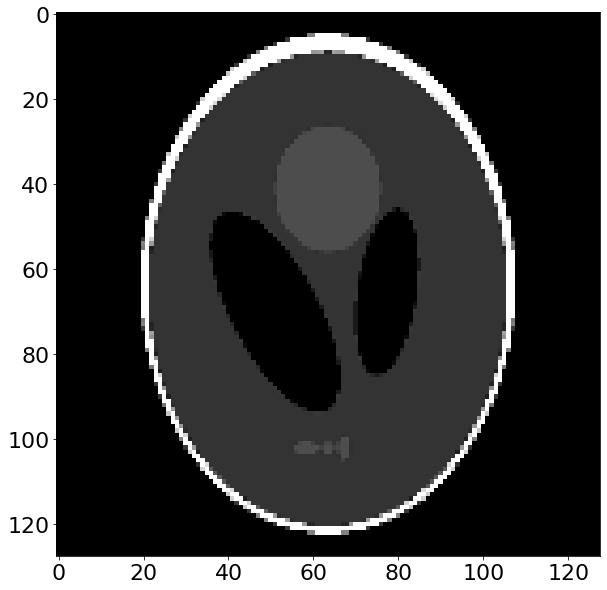

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(data, cmap=plt.cm.gray, interpolation='nearest')
# plt.colorbar(orientation='horizontal')
plt.show()

In [10]:
angles = np.arange(0,180,1./4)*np.pi/180

In [11]:
sinogram = astra_build_sinogram(data, angles)

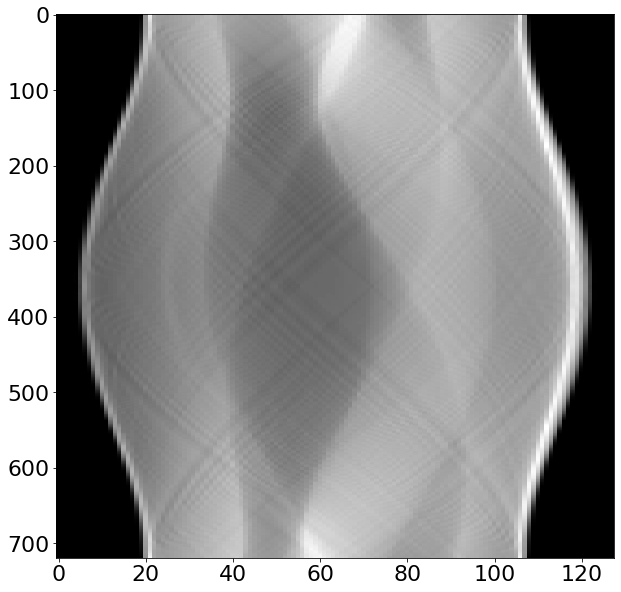

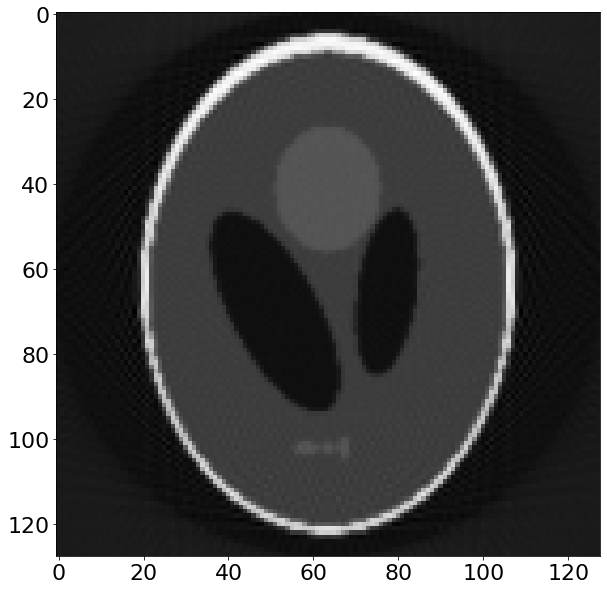

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(sinogram, cmap=plt.cm.gray, interpolation='nearest')
# plt.colorbar(orientation='horizontal')
plt.axis('tight')
plt.show()

rec, proj_geom, cfg = astra_tomo2d(sinogram, angles)

plt.figure(figsize=(10,10))
# plt.imshow(rec,vmin=0.1, vmax=0.2)
plt.imshow(rec, interpolation='nearest', cmap=plt.cm.gray)
# plt.colorbar(orientation='horizontal')
plt.show()

In [13]:
def get_x_cut(data):
    return np.arange(data.shape[0])-data.shape[0]//2, data[:,data.shape[1]//2]

def get_y_cut(data):
    return np.arange(data.shape[1])-data.shape[1]//2, data[data.shape[0]//2]

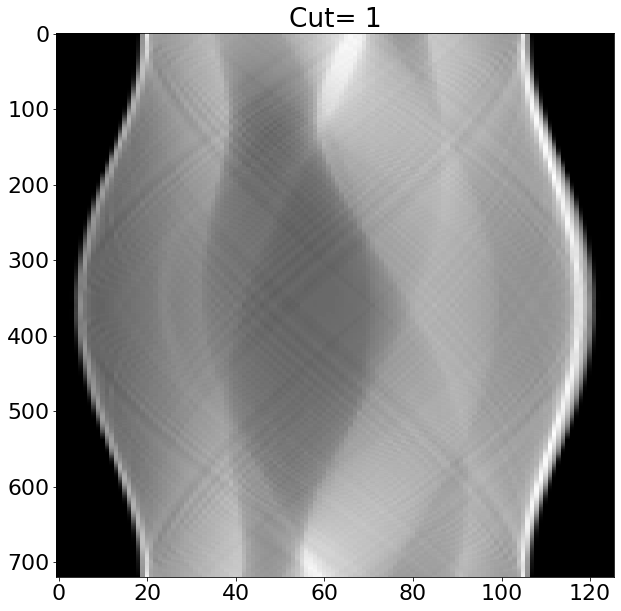

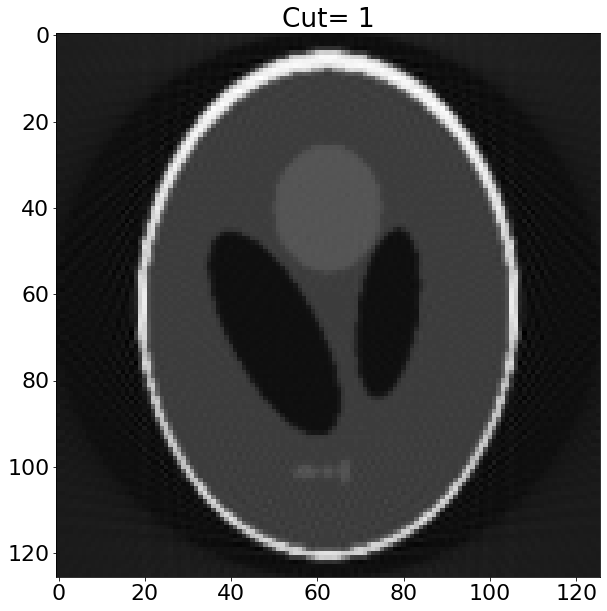

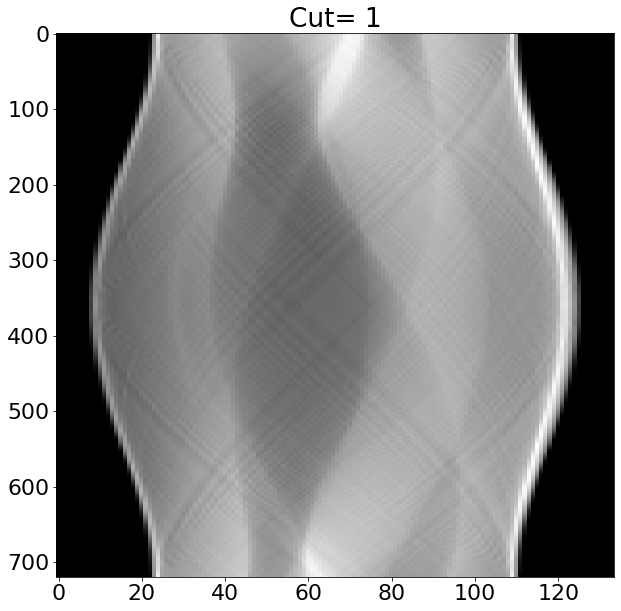

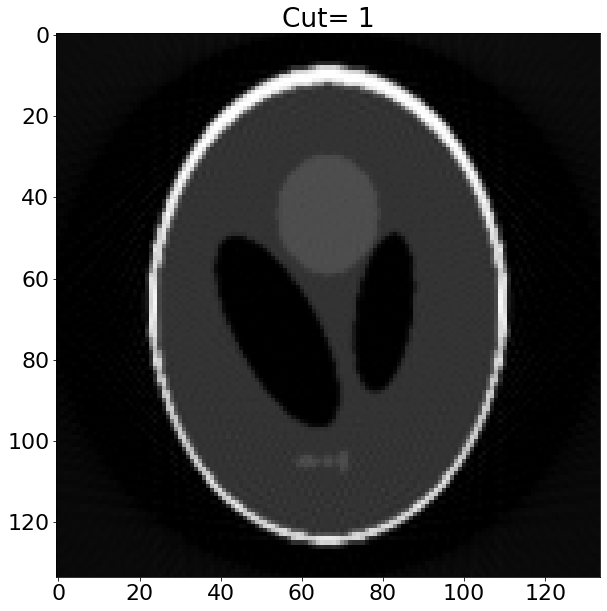

KeyboardInterrupt: 

In [15]:
for s_pad in tqdm_notebook(np.arange(1,62,4)):
    sinogram_cut = sinogram[:,s_pad:-s_pad]
    plt.figure(figsize=(10,10))
    plt.imshow(sinogram_cut, cmap=plt.cm.gray, interpolation='nearest')
    plt.axis('tight')
    plt.title('Cut= {}'.format(s_pad))
    plt.show()

    rec_cut, proj_geom, cfg = astra_tomo2d(sinogram_cut, angles)

    plt.figure(figsize=(10,10))
    plt.imshow(rec_cut, interpolation='nearest', cmap=plt.cm.gray)
    plt.title('Cut= {}'.format(s_pad))
    plt.show()
    
    #TODO: fixit
    padsize = s_pad*2*2

    sinogram_padded = np.zeros((sinogram_cut.shape[0],sinogram_cut.shape[1]+padsize*2), dtype='float32')
    sinogram_padded[:,padsize:-padsize] = sinogram_cut
    rec_pad0, proj_geom, cfg = astra_tomo2d(sinogram_padded, angles)
    
    plt.figure(figsize=(10,10))
    plt.imshow(sinogram_padded, cmap=plt.cm.gray, interpolation='nearest')
    plt.title('Cut= {}'.format(s_pad))
    plt.axis('tight')
    plt.show()

    plt.figure(figsize=(10,10))
    plt.imshow(rec_pad0, interpolation='nearest', cmap=plt.cm.gray, vmin=0, vmax=1)
    plt.title('Cut= {}'.format(s_pad))
    plt.show()
    
    rec_pad, proj_geom, cfg = astra_tomo2d(sinogram_padded, angles)
    sino = astra_build_sinogram(rec_pad, angles)
    sino[:,padsize:-padsize] = sinogram_cut

    max_radon=sino.sum(axis=1).max()

    MU = rec.sum()*2
    X,Y = np.meshgrid(np.arange(rec_pad.shape[0]),np.arange(rec_pad.shape[1]))

    X-=rec_pad.shape[0]//2
    Y-=rec_pad.shape[1]//2

    mask = (X**2+Y**2)<(rec.shape[0]//2)**2-10

    for i in tqdm_notebook(range(10000)):
        rec_pad, proj_geom, cfg = astra_tomo2d(sino, angles)
        rec_pad*=rec_pad>0
        rec_pad*=mask
        sino = astra_build_sinogram(rec_pad, angles)
        k = sino[:,padsize:-padsize].mean(axis=-1)/sinogram_cut.mean(axis=-1)
        if np.sum(np.argwhere(k==0))>0:
            break

        sino[:,padsize:-padsize] = sinogram_cut
        sino[:,0:padsize]=(sino[:,0:padsize].T/k).T
        sino[:,-padsize:]=(sino[:,-padsize:].T/k).T
        
        sino = (sino.T/sino.sum(axis=1)*sino.sum(axis=1).mean()).T
        sino[:,padsize:-padsize] = sinogram_cut

    rec_pad, proj_geom, cfg = astra_tomo2d(sino, angles)

    plt.figure(figsize=(10,10))
    plt.imshow(sino, cmap=plt.cm.gray, interpolation='nearest')
    plt.title('Cut= {}'.format(s_pad))
    plt.axis('tight')
    plt.colorbar()
    plt.show()

    plt.figure(figsize=(10,10))
    plt.imshow(rec_pad, interpolation='nearest', cmap=plt.cm.gray,vmin=0, vmax=1)
    plt.title('Cut= {}'.format(s_pad))
    plt.colorbar()
    plt.show()


    plt.figure(figsize=(10,5))
    plt.plot(*get_x_cut(rec_pad0), label='FBP')
    # plt.plot(*get_x_cut(rec_pad), label='rec_pad')
    plt.plot(*get_x_cut(rec_pad), label='Итеративный метод восстановления')
    plt.plot(*get_x_cut(rec), label='Исходный объект')
    plt.vlines([s_pad-64,64-s_pad-1],-0.1,1.6, 'k', '--')
    plt.grid()
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15))
    plt.xlim(-100,100)
    plt.ylabel('Поглощение')
    plt.xlabel('Номер канала детектора')
    plt.show()


    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.imshow(data, cmap=plt.cm.gray)
    plt.title('а')
    plt.vlines([s_pad,128-s_pad],s_pad,128-s_pad, 'r', lw=2)
    plt.hlines([s_pad,128-s_pad],s_pad,128-s_pad, 'r', lw=2)

    plt.subplot(122)

    plt.imshow(rec_pad[rec_pad.shape[0]//2-rec.shape[0]//2:rec_pad.shape[0]//2+rec.shape[0]//2,
                      rec_pad.shape[0]//2-rec.shape[0]//2:rec_pad.shape[0]//2+rec.shape[0]//2],
               interpolation='nearest', cmap=plt.cm.gray,vmax=1)

    plt.title('б')
#     plt.colorbar(orientation='vertical')
    plt.vlines([s_pad,128-s_pad],s_pad,128-s_pad, 'r', lw=2)
    plt.hlines([s_pad,128-s_pad],s_pad,128-s_pad, 'r', lw=2)
    plt.show()

    plt.figure(figsize=(5,5))

    plt.imshow(rec_pad0[rec_pad0.shape[0]//2-rec.shape[0]//2:rec_pad0.shape[0]//2+rec.shape[0]//2,
                      rec_pad0.shape[0]//2-rec.shape[0]//2:rec_pad0.shape[0]//2+rec.shape[0]//2],
               interpolation='nearest', cmap=plt.cm.gray,vmin=0, vmax=1)

    plt.title('в')
    
    plt.vlines([s_pad,128-s_pad],s_pad,128-s_pad, 'r', lw=2)
    plt.hlines([s_pad,128-s_pad],s_pad,128-s_pad, 'r', lw=2)
    plt.show()

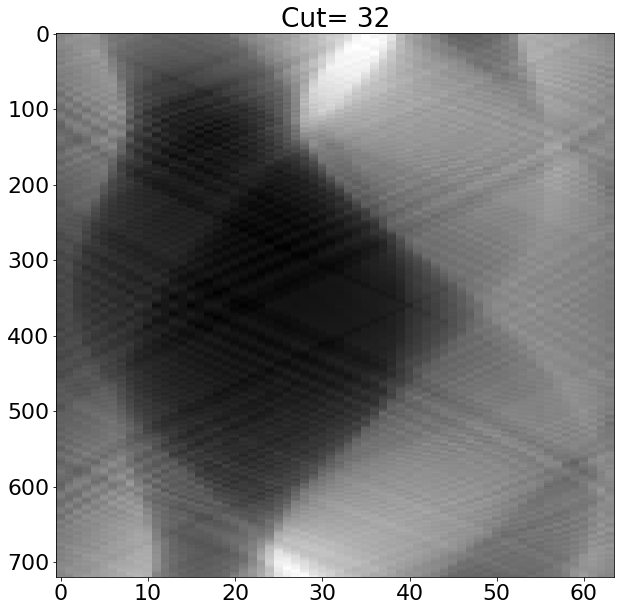

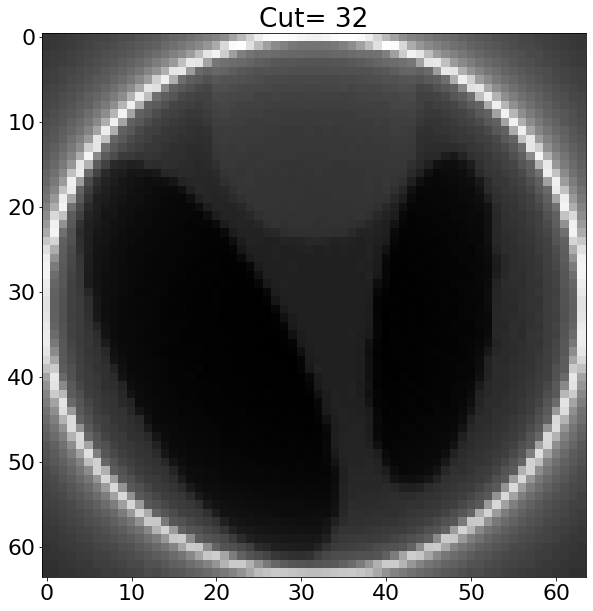

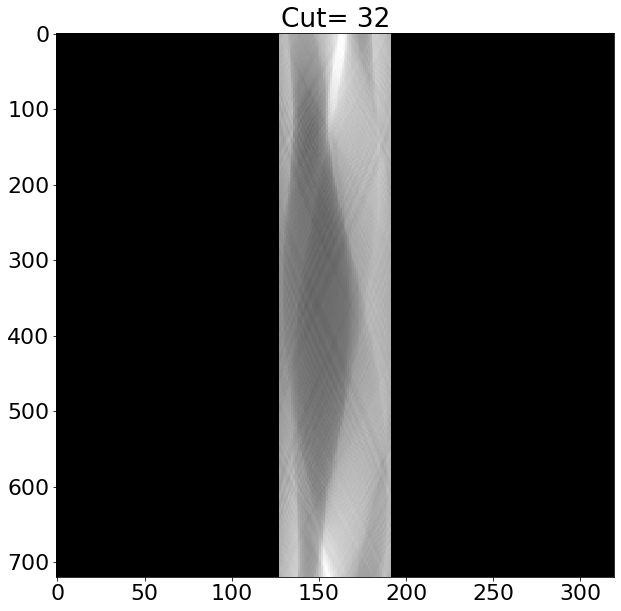

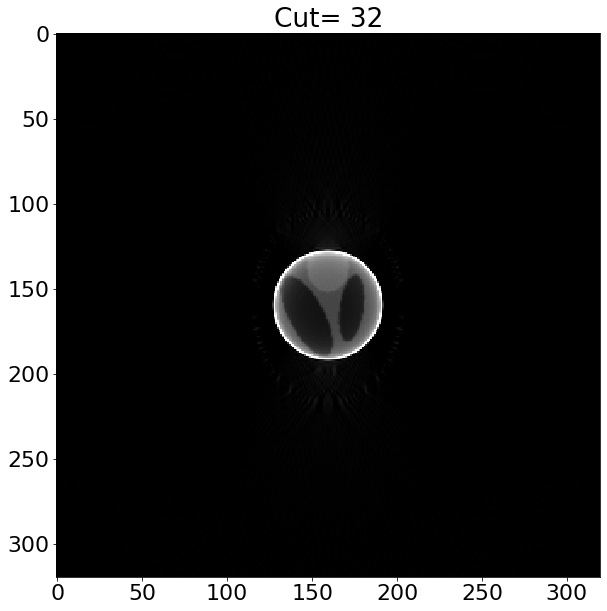

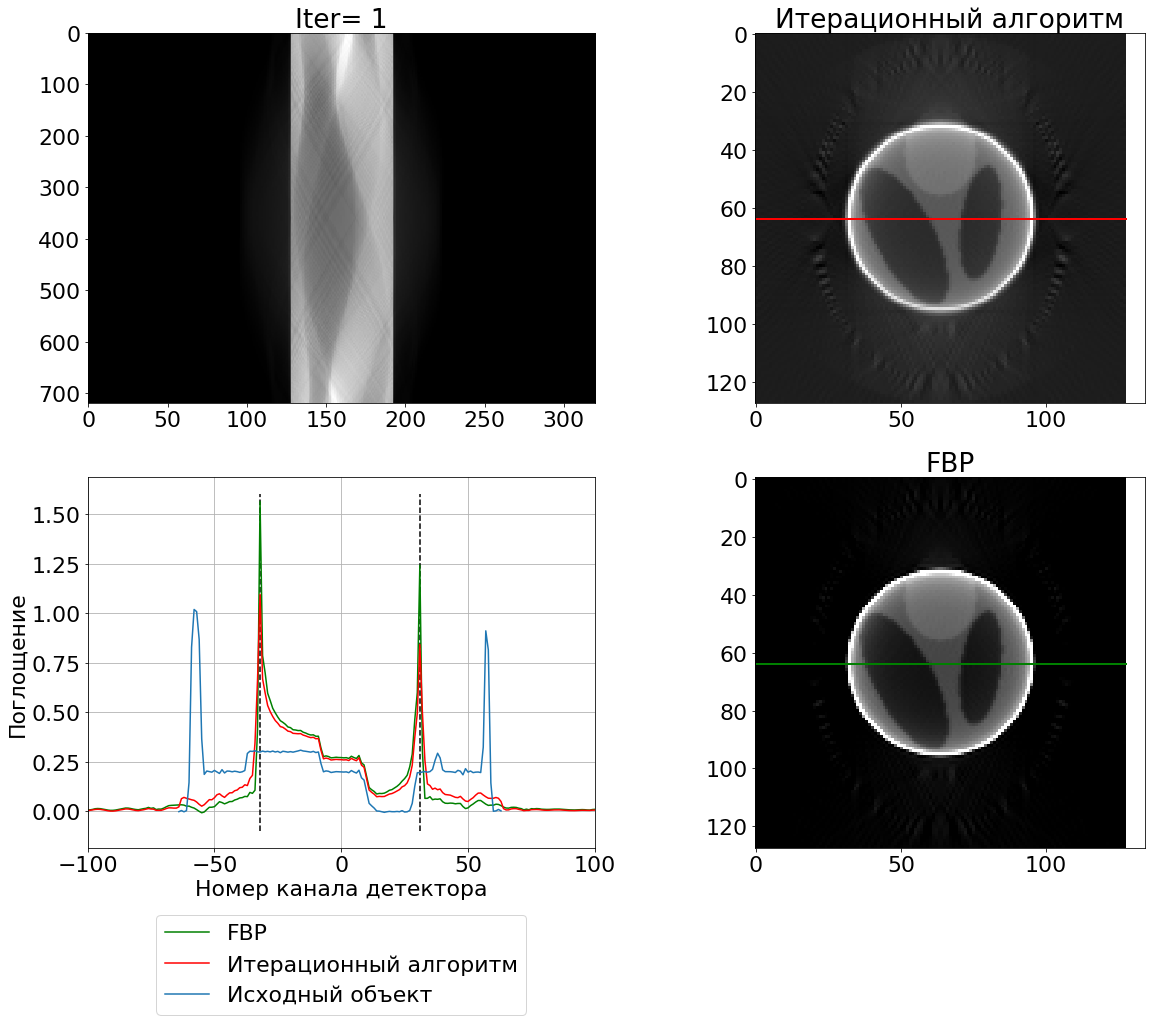

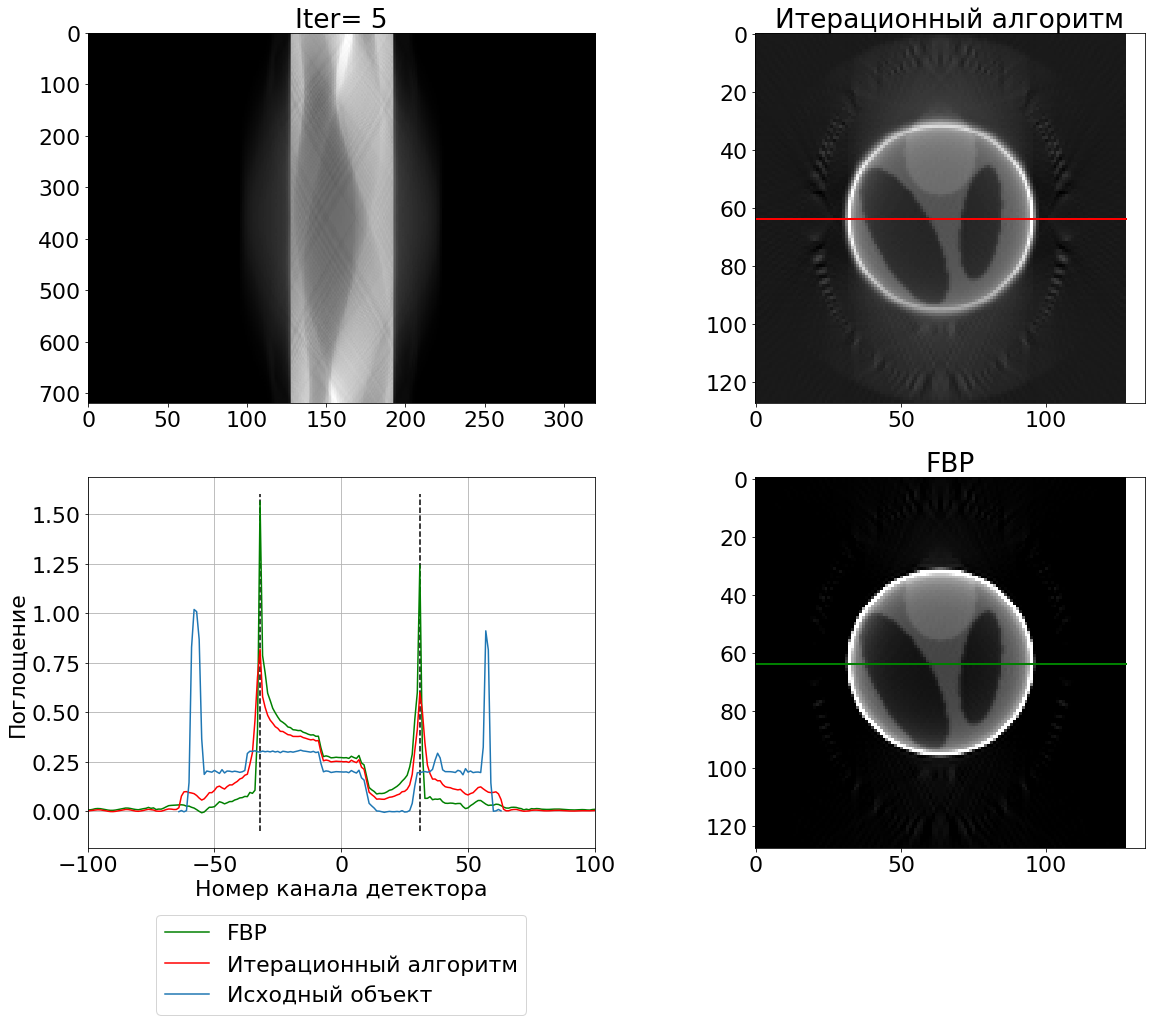

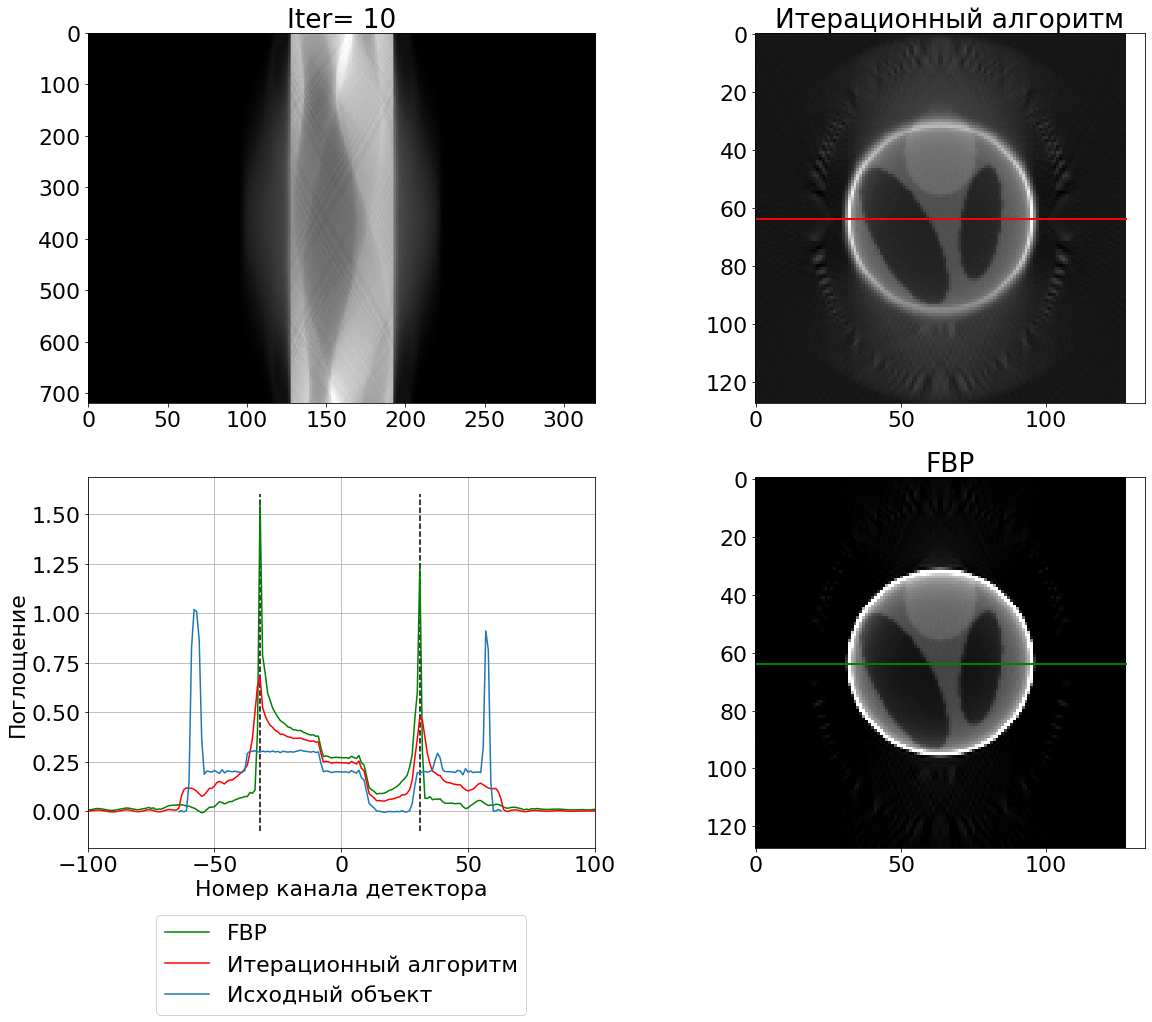

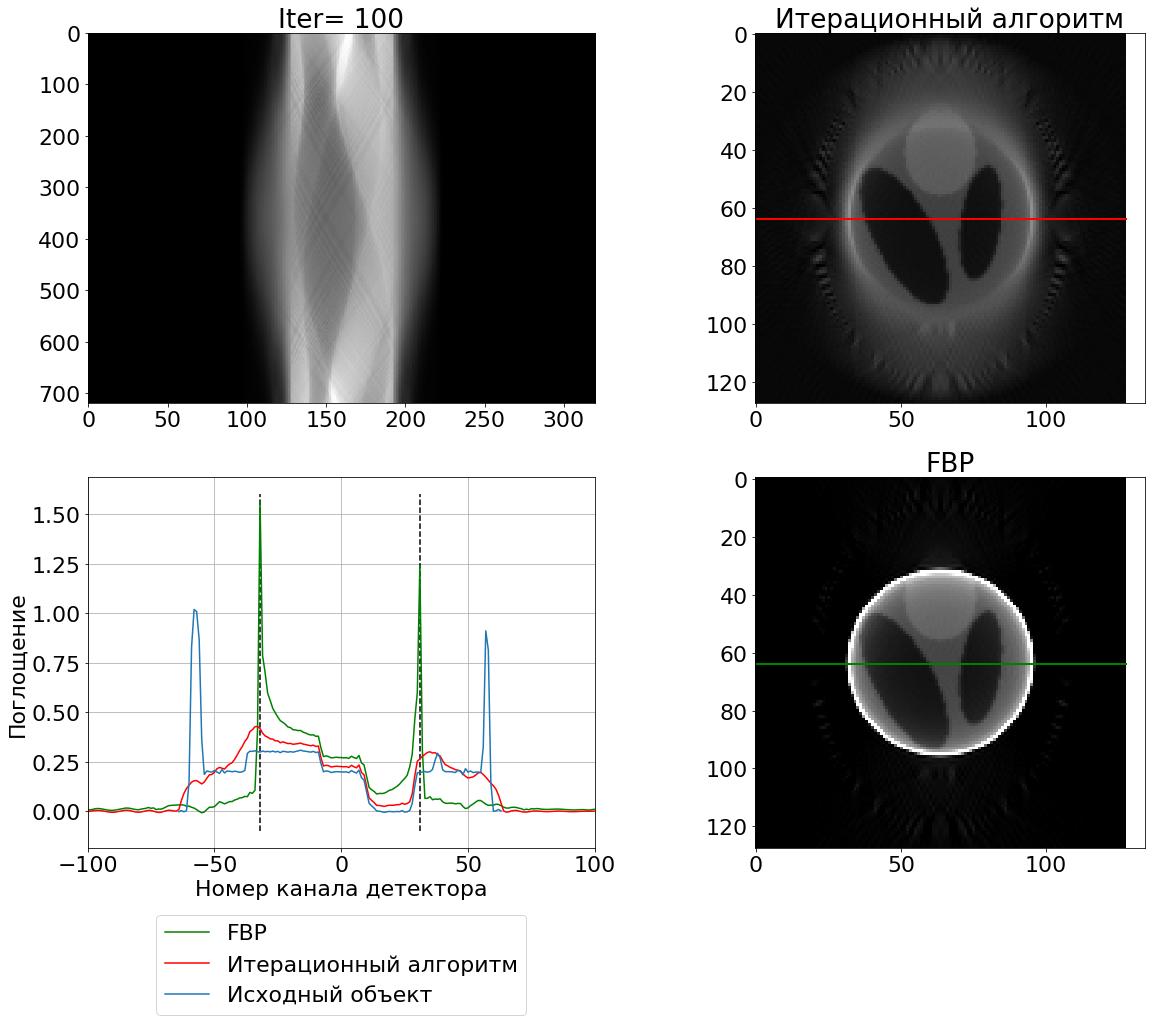

KeyboardInterrupt: 

In [16]:
for s_pad in tqdm_notebook(np.arange(32,33,1)):
    sinogram_cut = sinogram[:,s_pad:-s_pad]
    plt.figure(figsize=(10,10))
    plt.imshow(sinogram_cut, cmap=plt.cm.gray, interpolation='nearest')
    plt.axis('tight')
    plt.title('Cut= {}'.format(s_pad))
    plt.show()

    rec_cut, proj_geom, cfg = astra_tomo2d(sinogram_cut, angles)

    plt.figure(figsize=(10,10))
    plt.imshow(rec_cut, interpolation='nearest', cmap=plt.cm.gray)
    plt.title('Cut= {}'.format(s_pad))
    plt.show()
    
    #TODO: fixit
    padsize = s_pad*2*2

    sinogram_padded = np.zeros((sinogram_cut.shape[0],sinogram_cut.shape[1]+padsize*2), dtype='float32')
    sinogram_padded[:,padsize:-padsize] = sinogram_cut
    rec_pad0, proj_geom, cfg = astra_tomo2d(sinogram_padded, angles)
    
    plt.figure(figsize=(10,10))
    plt.imshow(sinogram_padded, cmap=plt.cm.gray, interpolation='nearest')
    plt.title('Cut= {}'.format(s_pad))
    plt.axis('tight')
    plt.show()

    plt.figure(figsize=(10,10))
    plt.imshow(rec_pad0, interpolation='nearest', cmap=plt.cm.gray, vmin=0, vmax=1)
    plt.title('Cut= {}'.format(s_pad))
    plt.show()
    
    rec_pad, proj_geom, cfg = astra_tomo2d(sinogram_padded, angles)
    sino = astra_build_sinogram(rec_pad, angles)
    sino[:,padsize:-padsize] = sinogram_cut

    max_radon=sino.sum(axis=1).max()

    MU = rec.sum()*2
    X,Y = np.meshgrid(np.arange(rec_pad.shape[0]),np.arange(rec_pad.shape[1]))

    X-=rec_pad.shape[0]//2
    Y-=rec_pad.shape[1]//2

    mask = (X**2+Y**2)<(rec.shape[0]//2)**2-10

    for i in tqdm_notebook(range(10001)):
        rec_pad, proj_geom, cfg = astra_tomo2d(sino, angles)
        rec_pad*=rec_pad>0
        rec_pad*=mask
        sino = astra_build_sinogram(rec_pad, angles)
        k = sino[:,padsize:-padsize].mean(axis=-1)/sinogram_cut.mean(axis=-1)
        if np.sum(np.argwhere(k==0))>0:
            break

        sino[:,padsize:-padsize] = sinogram_cut
        sino[:,0:padsize]=(sino[:,0:padsize].T/k).T
        sino[:,-padsize:]=(sino[:,-padsize:].T/k).T
        
        sino = (sino.T/sino.sum(axis=1)*sino.sum(axis=1).mean()).T
        sino[:,padsize:-padsize] = sinogram_cut
        if i in [1,5,10,100,500,1000,5000,10000]:

            rec_pad, proj_geom, cfg = astra_tomo2d(sino, angles)

            plt.figure(figsize=(20,15))
            plt.subplot(221)
            plt.imshow(sino, cmap=plt.cm.gray, interpolation='nearest')
            plt.title('Iter= {}'.format(i))
            plt.axis('tight')
#             plt.colorbar()
#             plt.show()

#             plt.subplot(221)
#             plt.imshow(rec_pad, interpolation='nearest', cmap=plt.cm.gray,vmin=0, vmax=1)
#             plt.title('Iter= {}'.format(i))
#             plt.colorbar()
#             plt.show()


#             plt.figure(figsize=(10,5))
            plt.subplot(223)
            plt.plot(*get_x_cut(rec_pad0), 'g', label='FBP')
            # plt.plot(*get_x_cut(rec_pad), label='rec_pad')
            plt.plot(*get_x_cut(rec_pad), 'r', label='Итерационный алгоритм')
            plt.plot(*get_x_cut(rec), label='Исходный объект')
            plt.vlines([s_pad-64,64-s_pad-1],-0.1,1.6, 'k', '--')
            plt.grid()
            plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15))
            plt.xlim(-100,100)
            plt.ylabel('Поглощение')
            plt.xlabel('Номер канала детектора')
#             plt.show()


#             plt.figure(figsize=(10,5))
#             plt.subplot(121)
#             plt.imshow(data, cmap=plt.cm.gray)
#             plt.title('а')
#             plt.vlines([s_pad,128-s_pad],s_pad,128-s_pad, 'r', lw=2)
#             plt.hlines([s_pad,128-s_pad],s_pad,128-s_pad, 'r', lw=2)

            plt.subplot(222)

            plt.imshow(rec_pad[rec_pad.shape[0]//2-rec.shape[0]//2:rec_pad.shape[0]//2+rec.shape[0]//2,
                              rec_pad.shape[0]//2-rec.shape[0]//2:rec_pad.shape[0]//2+rec.shape[0]//2],
                       interpolation='nearest', cmap=plt.cm.gray,vmax=1)

            plt.title('Итерационный алгоритм')
        #     plt.colorbar(orientation='vertical')
#             plt.vlines([s_pad,128-s_pad],s_pad,128-s_pad, 'r', lw=2)
            plt.hlines([64],0,128, 'r', lw=2)
#             plt.show()

#             plt.figure(figsize=(5,5))
            plt.subplot(224)
            plt.imshow(rec_pad0[rec_pad0.shape[0]//2-rec.shape[0]//2:rec_pad0.shape[0]//2+rec.shape[0]//2,
                              rec_pad0.shape[0]//2-rec.shape[0]//2:rec_pad0.shape[0]//2+rec.shape[0]//2],
                       interpolation='nearest', cmap=plt.cm.gray,vmin=0, vmax=1)

            plt.title('FBP')
            
#             plt.vlines([s_pad,128-s_pad],s_pad,128-s_pad, 'r', lw=2)
#             plt.hlines([s_pad,128-s_pad],s_pad,128-s_pad, 'r', lw=2)
            plt.hlines([64],0,128, 'g', lw=2)
            plt.show()

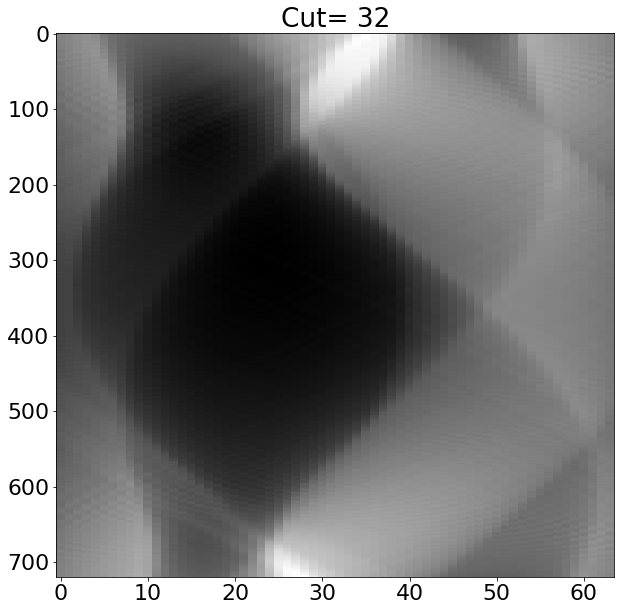

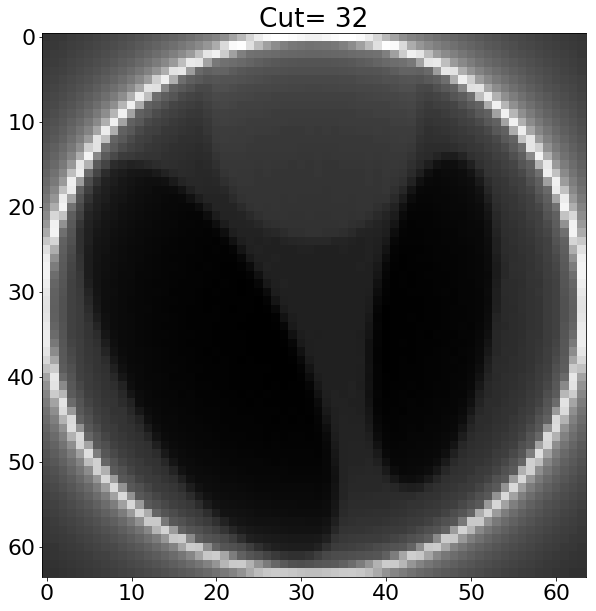

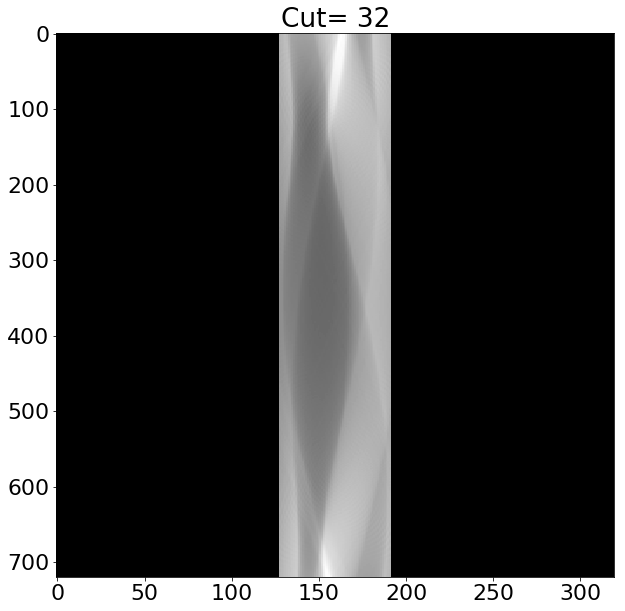

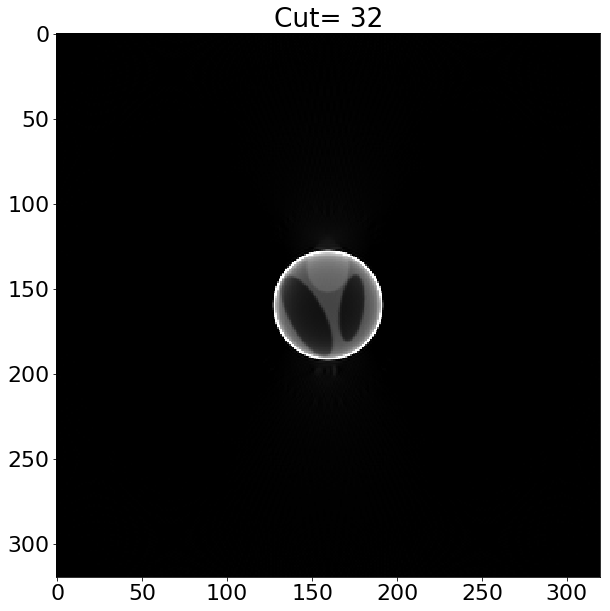

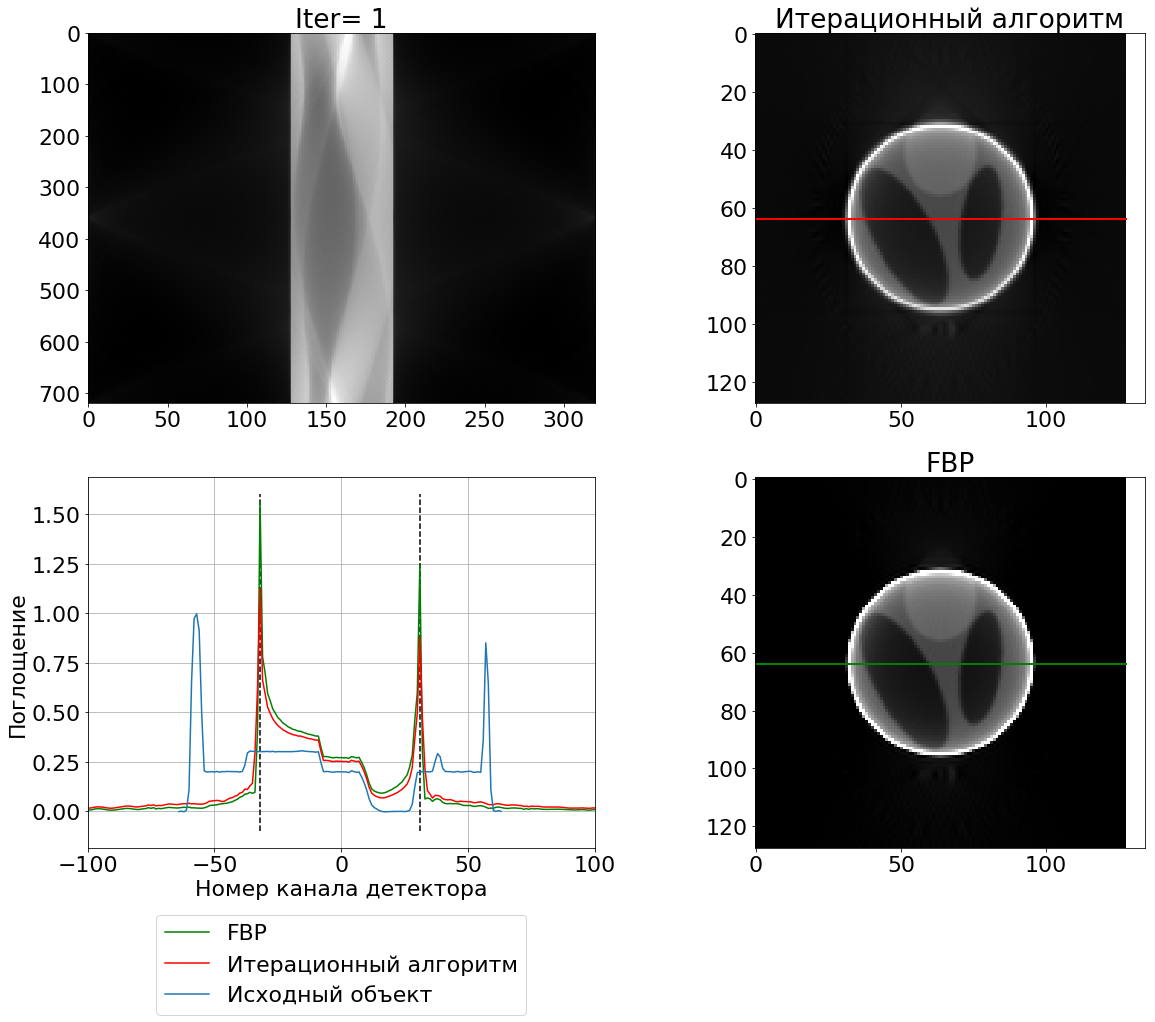

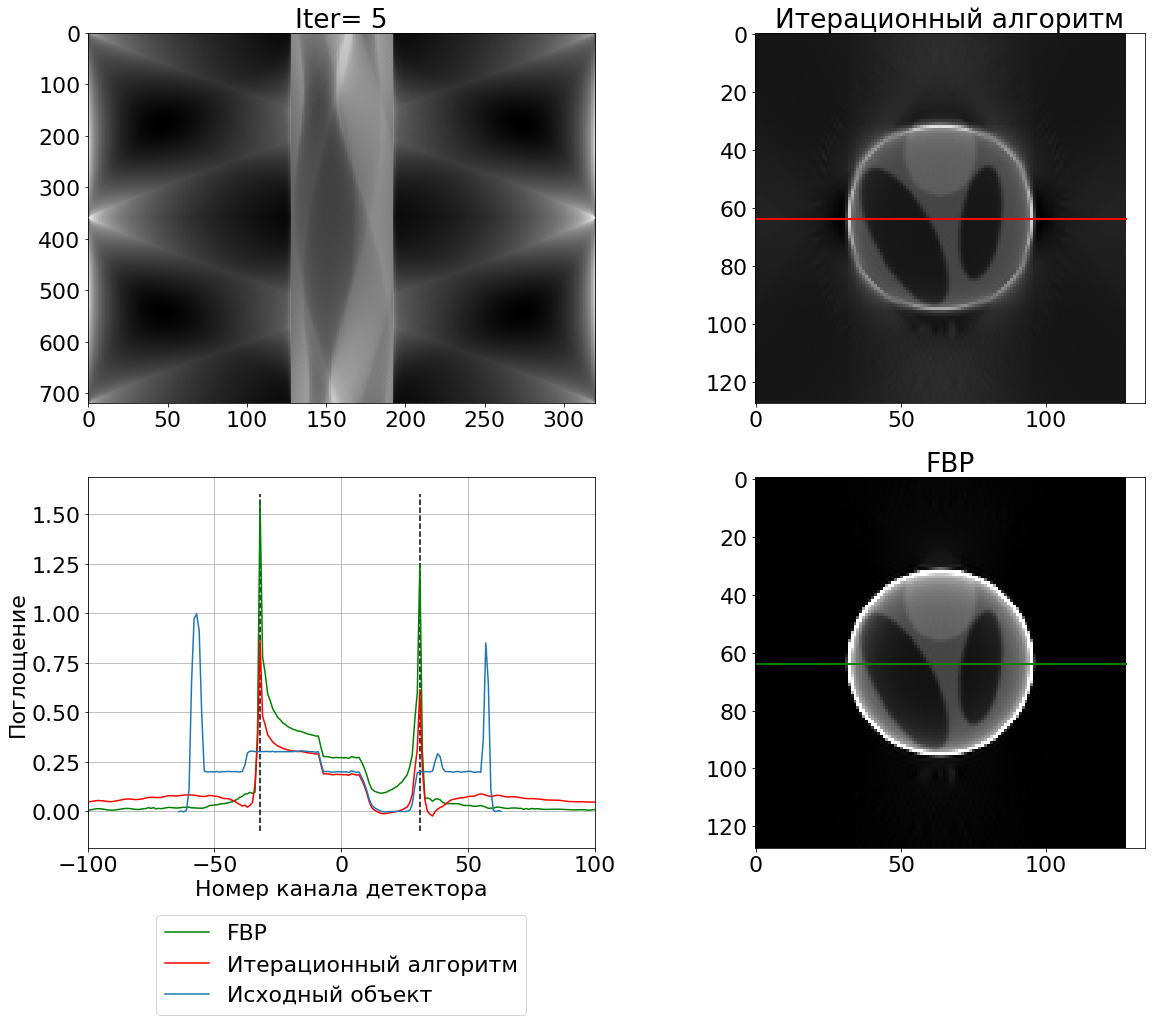

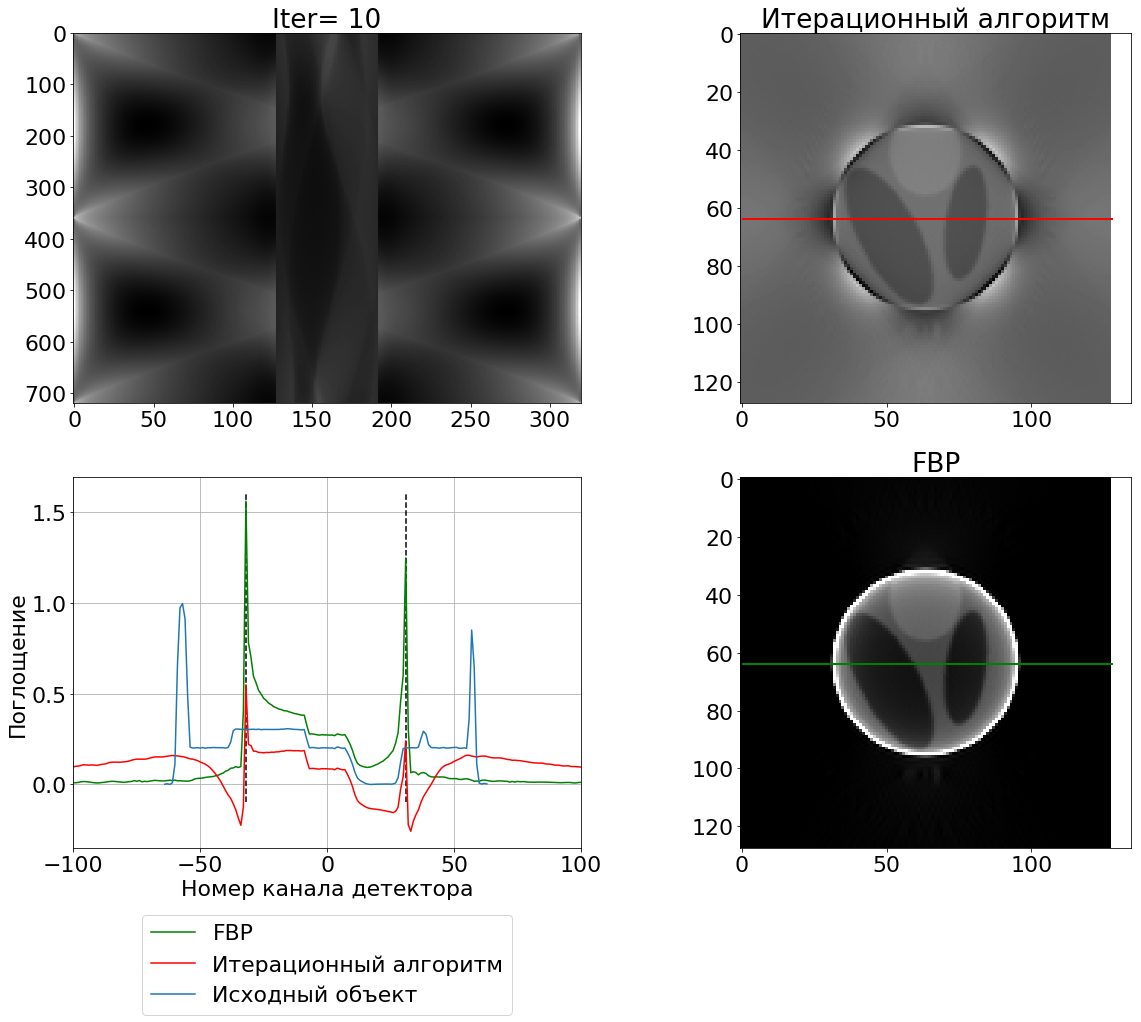

In [13]:
for s_pad in log_progress(np.arange(32,33,1)):
    sinogram_cut = sinogram[:,s_pad:-s_pad]
    plt.figure(figsize=(10,10))
    plt.imshow(sinogram_cut, cmap=plt.cm.gray, interpolation='nearest')
    plt.axis('tight')
    plt.title('Cut= {}'.format(s_pad))
    plt.show()

    rec_cut, proj_geom, cfg = astra_tomo2d(sinogram_cut, angles)

    plt.figure(figsize=(10,10))
    plt.imshow(rec_cut, interpolation='nearest', cmap=plt.cm.gray)
    plt.title('Cut= {}'.format(s_pad))
    plt.show()
    
    #TODO: fixit
    padsize = s_pad*2*2

    sinogram_padded = np.zeros((sinogram_cut.shape[0],sinogram_cut.shape[1]+padsize*2), dtype='float32')
    sinogram_padded[:,padsize:-padsize] = sinogram_cut
    rec_pad0, proj_geom, cfg = astra_tomo2d(sinogram_padded, angles)
    
    plt.figure(figsize=(10,10))
    plt.imshow(sinogram_padded, cmap=plt.cm.gray, interpolation='nearest')
    plt.title('Cut= {}'.format(s_pad))
    plt.axis('tight')
    plt.show()

    plt.figure(figsize=(10,10))
    plt.imshow(rec_pad0, interpolation='nearest', cmap=plt.cm.gray, vmin=0, vmax=1)
    plt.title('Cut= {}'.format(s_pad))
    plt.show()
    
    rec_pad, proj_geom, cfg = astra_tomo2d(sinogram_padded, angles)
    sino = astra_build_sinogram(rec_pad, angles)
    sino[:,padsize:-padsize] = sinogram_cut

    max_radon=sino.sum(axis=1).max()

    MU = rec.sum()*2
    X,Y = np.meshgrid(np.arange(rec_pad.shape[0]),np.arange(rec_pad.shape[1]))

    X-=rec_pad.shape[0]//2
    Y-=rec_pad.shape[1]//2

    mask = (X**2+Y**2)<(rec.shape[0]//2)**2-10

    for i in log_progress(range(100)):
        rec_pad, proj_geom, cfg = astra_tomo2d(sino, angles)
        rec_pad*=rec_pad>0
#         rec_pad*=mask
        sino = astra_build_sinogram(rec_pad, angles)
        k = sino[:,padsize:-padsize].mean(axis=-1)/sinogram_cut.mean(axis=-1)
        if np.sum(np.argwhere(k==0))>0:
            break

        sino[:,padsize:-padsize] = sinogram_cut
        sino[:,0:padsize]=(sino[:,0:padsize].T/k).T
        sino[:,-padsize:]=(sino[:,-padsize:].T/k).T
        
        sino = (sino.T/sino.sum(axis=1)*sino.sum(axis=1).mean()).T
        sino[:,padsize:-padsize] = sinogram_cut
        if i in [1,5,10,100,500,1000,5000,10000]:

            rec_pad, proj_geom, cfg = astra_tomo2d(sino, angles)

            plt.figure(figsize=(20,15))
            plt.subplot(221)
            plt.imshow(sino, cmap=plt.cm.gray, interpolation='nearest')
            plt.title('Iter= {}'.format(i))
            plt.axis('tight')
#             plt.colorbar()
#             plt.show()

#             plt.subplot(221)
#             plt.imshow(rec_pad, interpolation='nearest', cmap=plt.cm.gray,vmin=0, vmax=1)
#             plt.title('Iter= {}'.format(i))
#             plt.colorbar()
#             plt.show()


#             plt.figure(figsize=(10,5))
            plt.subplot(223)
            plt.plot(*get_x_cut(rec_pad0), 'g', label='FBP')
            # plt.plot(*get_x_cut(rec_pad), label='rec_pad')
            plt.plot(*get_x_cut(rec_pad), 'r', label='Итерационный алгоритм')
            plt.plot(*get_x_cut(rec), label='Исходный объект')
            plt.vlines([s_pad-64,64-s_pad-1],-0.1,1.6, 'k', '--')
            plt.grid()
            plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15))
            plt.xlim(-100,100)
            plt.ylabel('Поглощение')
            plt.xlabel('Номер канала детектора')
#             plt.show()


#             plt.figure(figsize=(10,5))
#             plt.subplot(121)
#             plt.imshow(data, cmap=plt.cm.gray)
#             plt.title('а')
#             plt.vlines([s_pad,128-s_pad],s_pad,128-s_pad, 'r', lw=2)
#             plt.hlines([s_pad,128-s_pad],s_pad,128-s_pad, 'r', lw=2)

            plt.subplot(222)

            plt.imshow(rec_pad[rec_pad.shape[0]//2-rec.shape[0]//2:rec_pad.shape[0]//2+rec.shape[0]//2,
                              rec_pad.shape[0]//2-rec.shape[0]//2:rec_pad.shape[0]//2+rec.shape[0]//2],
                       interpolation='nearest', cmap=plt.cm.gray,vmax=1)

            plt.title('Итерационный алгоритм')
        #     plt.colorbar(orientation='vertical')
#             plt.vlines([s_pad,128-s_pad],s_pad,128-s_pad, 'r', lw=2)
            plt.hlines([64],0,128, 'r', lw=2)
#             plt.show()

#             plt.figure(figsize=(5,5))
            plt.subplot(224)
            plt.imshow(rec_pad0[rec_pad0.shape[0]//2-rec.shape[0]//2:rec_pad0.shape[0]//2+rec.shape[0]//2,
                              rec_pad0.shape[0]//2-rec.shape[0]//2:rec_pad0.shape[0]//2+rec.shape[0]//2],
                       interpolation='nearest', cmap=plt.cm.gray,vmin=0, vmax=1)

            plt.title('FBP')
            
#             plt.vlines([s_pad,128-s_pad],s_pad,128-s_pad, 'r', lw=2)
#             plt.hlines([s_pad,128-s_pad],s_pad,128-s_pad, 'r', lw=2)
            plt.hlines([64],0,128, 'g', lw=2)
            plt.show()

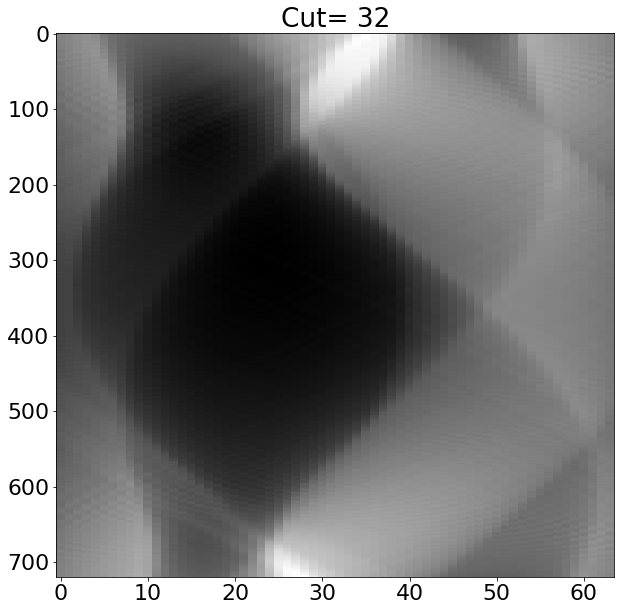

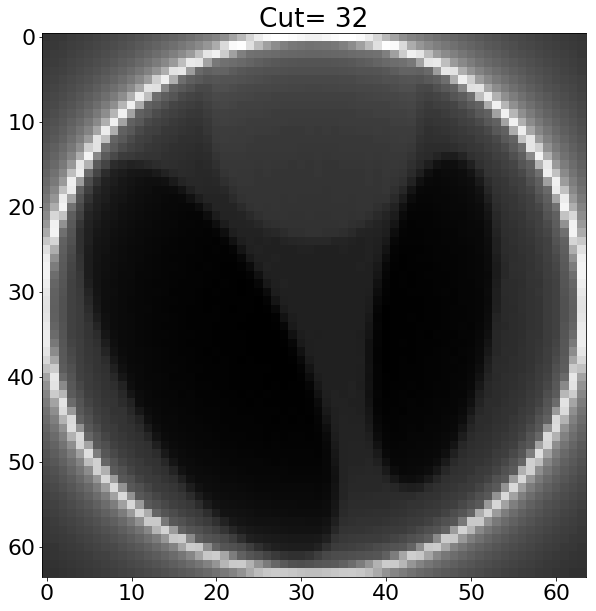

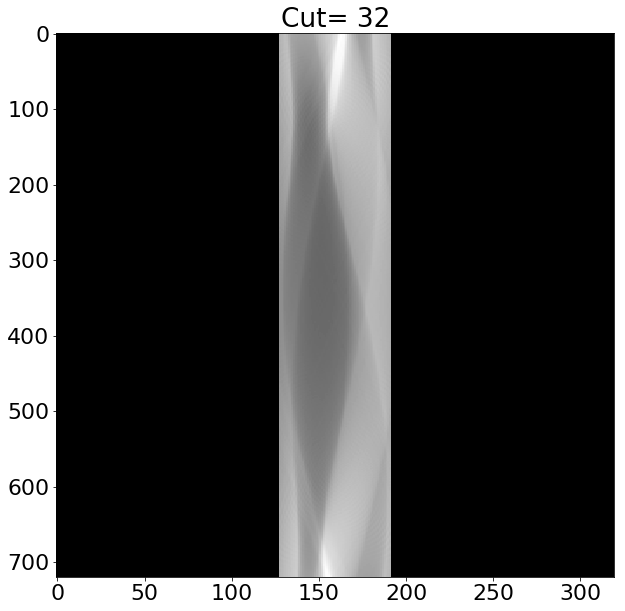

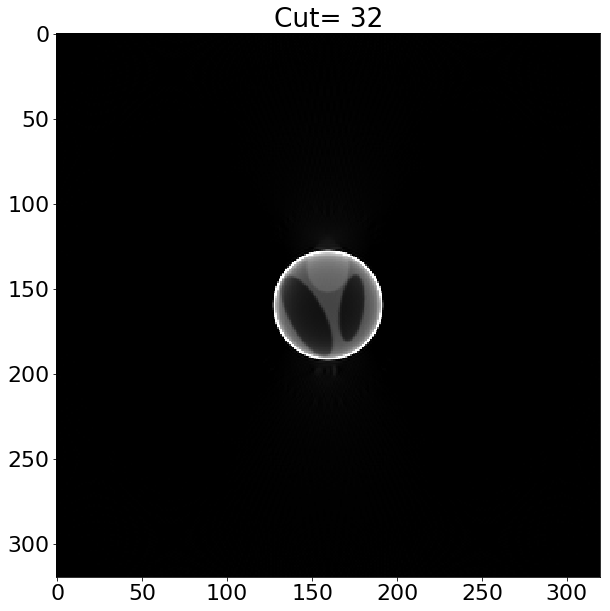

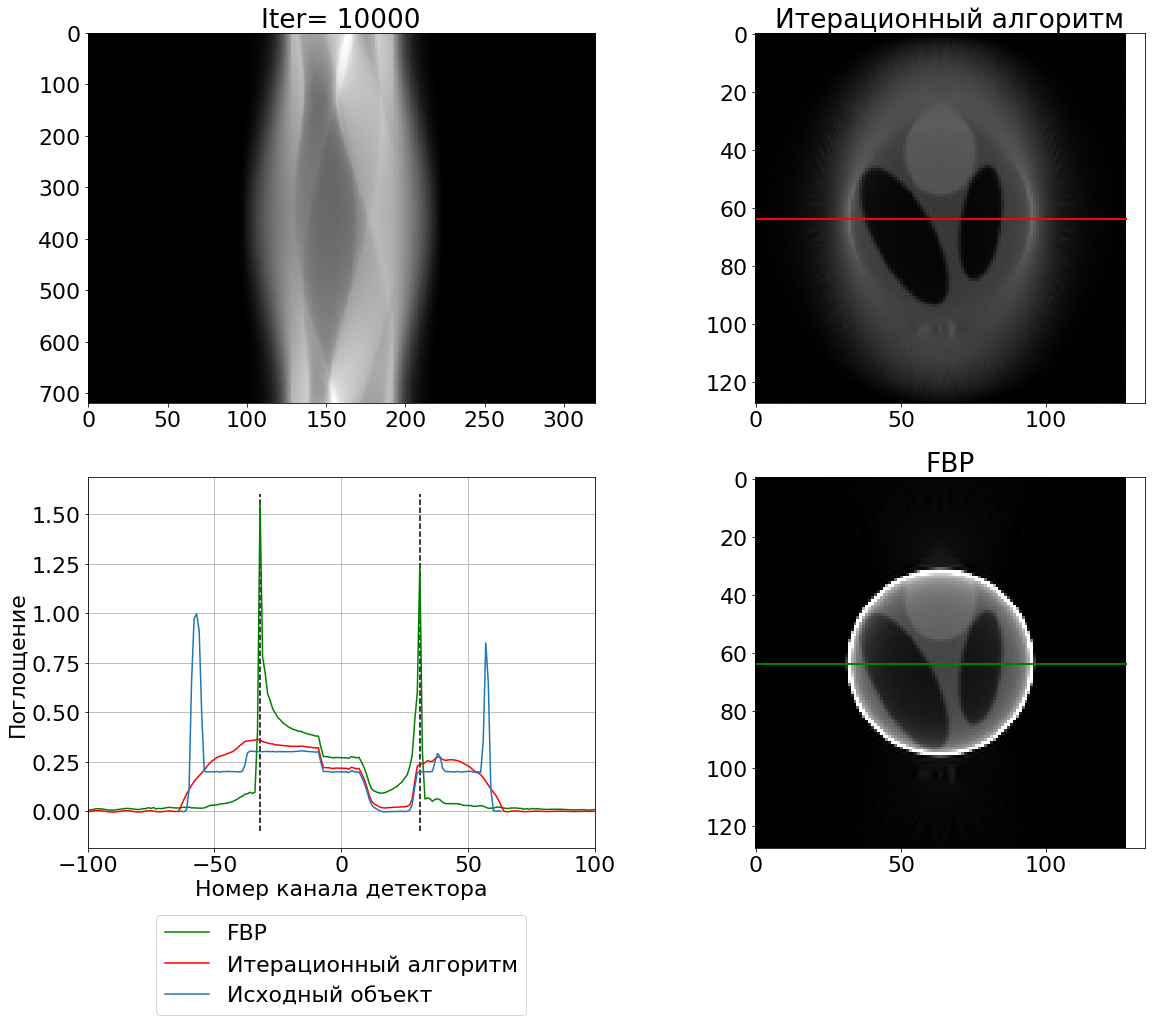

In [16]:
for s_pad in log_progress(np.arange(32,33,1)):
    sinogram_cut = sinogram[:,s_pad:-s_pad]
    plt.figure(figsize=(10,10))
    plt.imshow(sinogram_cut, cmap=plt.cm.gray, interpolation='nearest')
    plt.axis('tight')
    plt.title('Cut= {}'.format(s_pad))
    plt.show()

    rec_cut, proj_geom, cfg = astra_tomo2d(sinogram_cut, angles)

    plt.figure(figsize=(10,10))
    plt.imshow(rec_cut, interpolation='nearest', cmap=plt.cm.gray)
    plt.title('Cut= {}'.format(s_pad))
    plt.show()
    
    #TODO: fixit
    padsize = s_pad*2*2

    sinogram_padded = np.zeros((sinogram_cut.shape[0],sinogram_cut.shape[1]+padsize*2), dtype='float32')
    sinogram_padded[:,padsize:-padsize] = sinogram_cut
    rec_pad0, proj_geom, cfg = astra_tomo2d(sinogram_padded, angles)
    
    plt.figure(figsize=(10,10))
    plt.imshow(sinogram_padded, cmap=plt.cm.gray, interpolation='nearest')
    plt.title('Cut= {}'.format(s_pad))
    plt.axis('tight')
    plt.show()

    plt.figure(figsize=(10,10))
    plt.imshow(rec_pad0, interpolation='nearest', cmap=plt.cm.gray, vmin=0, vmax=1)
    plt.title('Cut= {}'.format(s_pad))
    plt.show()
    
    rec_pad, proj_geom, cfg = astra_tomo2d(sinogram_padded, angles)
    sino = astra_build_sinogram(rec_pad, angles)
    sino[:,padsize:-padsize] = sinogram_cut

    max_radon=sino.sum(axis=1).max()

    MU = rec.sum()*2
    X,Y = np.meshgrid(np.arange(rec_pad.shape[0]),np.arange(rec_pad.shape[1]))

    X-=rec_pad.shape[0]//2
    Y-=rec_pad.shape[1]//2

    mask = (X**2+Y**2)<(rec.shape[0]//2)**2-10

    for i in log_progress(range(10001)):
        rec_pad, proj_geom, cfg = astra_tomo2d(sino, angles)
        rec_pad*=rec_pad>0
        rec_pad*=mask
        sino = astra_build_sinogram(rec_pad, angles)
        k = sino[:,padsize:-padsize].mean(axis=-1)/sinogram_cut.mean(axis=-1)
        if np.sum(np.argwhere(k==0))>0:
            break

        sino[:,padsize:-padsize] = sinogram_cut
#         sino[:,0:padsize]=(sino[:,0:padsize].T/k).T
#         sino[:,-padsize:]=(sino[:,-padsize:].T/k).T
        
#         sino = (sino.T/sino.sum(axis=1)*sino.sum(axis=1).mean()).T
        sino[:,padsize:-padsize] = sinogram_cut
        if i in [10000,]:

            rec_pad, proj_geom, cfg = astra_tomo2d(sino, angles)

            plt.figure(figsize=(20,15))
            plt.subplot(221)
            plt.imshow(sino, cmap=plt.cm.gray, interpolation='nearest')
            plt.title('Iter= {}'.format(i))
            plt.axis('tight')
#             plt.colorbar()
#             plt.show()

#             plt.subplot(221)
#             plt.imshow(rec_pad, interpolation='nearest', cmap=plt.cm.gray,vmin=0, vmax=1)
#             plt.title('Iter= {}'.format(i))
#             plt.colorbar()
#             plt.show()


#             plt.figure(figsize=(10,5))
            plt.subplot(223)
            plt.plot(*get_x_cut(rec_pad0), 'g', label='FBP')
            # plt.plot(*get_x_cut(rec_pad), label='rec_pad')
            plt.plot(*get_x_cut(rec_pad), 'r', label='Итерационный алгоритм')
            plt.plot(*get_x_cut(rec), label='Исходный объект')
            plt.vlines([s_pad-64,64-s_pad-1],-0.1,1.6, 'k', '--')
            plt.grid()
            plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15))
            plt.xlim(-100,100)
            plt.ylabel('Поглощение')
            plt.xlabel('Номер канала детектора')
#             plt.show()


#             plt.figure(figsize=(10,5))
#             plt.subplot(121)
#             plt.imshow(data, cmap=plt.cm.gray)
#             plt.title('а')
#             plt.vlines([s_pad,128-s_pad],s_pad,128-s_pad, 'r', lw=2)
#             plt.hlines([s_pad,128-s_pad],s_pad,128-s_pad, 'r', lw=2)

            plt.subplot(222)

            plt.imshow(rec_pad[rec_pad.shape[0]//2-rec.shape[0]//2:rec_pad.shape[0]//2+rec.shape[0]//2,
                              rec_pad.shape[0]//2-rec.shape[0]//2:rec_pad.shape[0]//2+rec.shape[0]//2],
                       interpolation='nearest', cmap=plt.cm.gray,vmax=1)

            plt.title('Итерационный алгоритм')
        #     plt.colorbar(orientation='vertical')
#             plt.vlines([s_pad,128-s_pad],s_pad,128-s_pad, 'r', lw=2)
            plt.hlines([64],0,128, 'r', lw=2)
#             plt.show()

#             plt.figure(figsize=(5,5))
            plt.subplot(224)
            plt.imshow(rec_pad0[rec_pad0.shape[0]//2-rec.shape[0]//2:rec_pad0.shape[0]//2+rec.shape[0]//2,
                              rec_pad0.shape[0]//2-rec.shape[0]//2:rec_pad0.shape[0]//2+rec.shape[0]//2],
                       interpolation='nearest', cmap=plt.cm.gray,vmin=0, vmax=1)

            plt.title('FBP')
            
#             plt.vlines([s_pad,128-s_pad],s_pad,128-s_pad, 'r', lw=2)
#             plt.hlines([s_pad,128-s_pad],s_pad,128-s_pad, 'r', lw=2)
            plt.hlines([64],0,128, 'g', lw=2)
            plt.show()

In [29]:
# plt.figure(figsize=(10,10))
# plt.imshow(sinogram_cut, cmap=plt.cm.gray, interpolation='nearest')
# plt.colorbar(orientation='horizontal')
# plt.axis('tight')
# plt.show()

# rec_cut, proj_geom, cfg = astra_tomo2d(sinogram_cut, angles)

# plt.figure(figsize=(10,10))
# # plt.imshow(rec,vmin=0.1, vmax=0.2)
# plt.imshow(rec_cut, interpolation='nearest', cmap=plt.cm.gray)
# plt.colorbar(orientation='horizontal')
# plt.show()

In [164]:
# padsize = s_pad*2*2

# sinogram_padded = np.zeros((sinogram_cut.shape[0],sinogram_cut.shape[1]+padsize*2), dtype='float32')
# sinogram_padded[:,padsize:-padsize] = sinogram_cut
# rec_pad0, proj_geom, cfg = astra_tomo2d(sinogram_padded, angles)

In [33]:
# plt.figure(figsize=(10,10))
# plt.imshow(sinogram_padded, cmap=plt.cm.gray, interpolation='nearest')
# plt.colorbar(orientation='horizontal')
# plt.axis('tight')
# plt.show()

# plt.figure(figsize=(10,10))
# # plt.imshow(rec,vmin=0.1, vmax=0.2)
# plt.imshow(rec_pad0, interpolation='nearest', cmap=plt.cm.gray, vmax=1)
# plt.colorbar(orientation='horizontal')
# plt.show()

In [166]:
import scipy.ndimage
def my_rc(sino0, level):
    def get_my_b(level):
        t= np.mean(sino0, axis=0)
        gt = scipy.ndimage.filters.gaussian_filter1d(t,level/2.)
        return gt-t
    
    def get_my_a(level):
        my_b = get_my_b(level)
        return np.mean(my_b)/my_b.shape[0]
    
    my_a = get_my_a(level)
    my_b = get_my_b(level)
    
    res = sino0.copy()
    if not level==0:
        res+= sino0*my_a+my_b
    
    return res

In [34]:

# rec_pad, proj_geom, cfg = astra_tomo2d(sinogram_padded, angles)
# sino = astra_build_sinogram(rec_pad, angles)
# sino[:,padsize:-padsize] = sinogram_cut

# max_radon=sino.sum(axis=1).max()

# MU = rec.sum()*2
# X,Y = np.meshgrid(np.arange(rec_pad.shape[0]),np.arange(rec_pad.shape[1]))

# X-=rec_pad.shape[0]//2
# Y-=rec_pad.shape[1]//2

# mask = (X**2+Y**2)<(rec.shape[0]//2)**2-10

# # for i in log_progress(range(1000)):
# #     rec_pad, proj_geom, cfg = astra_tomo2d(sino, angles)
    
# #     rec_pad*=rec_pad>0
# #     rec_pad*=mask
# #     rec_pad[rec_pad>1] = 1
# # #     if rec_pad.sum()>MU:
# # #         rec_pad = rec_pad/rec_pad.sum()*MU
# #     sino = astra_build_sinogram(rec_pad, angles)
    
# #     if i < 150:
# #         sino = my_rc(sino, 150-i)
        
# #     sino[:,padsize:-padsize] = sinogram_cut

# for i in log_progress(range(1000)):
#     rec_pad, proj_geom, cfg = astra_tomo2d(sino, angles)
#     rec_pad*=rec_pad>0
#     rec_pad*=mask
# #     rec_pad[rec_pad>1] = 1
#     sino = astra_build_sinogram(rec_pad, angles)
    
# #     sino = (sino.T/sino.sum(axis=1)*sinogram_cut.mean()).T
# #   t = sino[:,pad_size:-shift-pad_size]
# #     sino[:,padsize:-padsize] = (sinogram_cut+sino[:,padsize:-padsize])/2.
#     sino[:,padsize:-padsize] = sinogram_cut
#     sino = (sino.T/sino.sum(axis=1)*max_radon*1.4).T
#     sino[:,padsize:-padsize] = sinogram_cut

# rec_pad, proj_geom, cfg = astra_tomo2d(sino, angles)

# plt.figure(figsize=(10,10))
# plt.imshow(sino, cmap=plt.cm.gray, interpolation='nearest')
# plt.colorbar(orientation='horizontal')
# plt.axis('tight')
# plt.show()

# plt.figure(figsize=(10,10))
# # plt.imshow(rec,vmin=0.1, vmax=0.2)
# plt.imshow(rec_pad, interpolation='nearest', cmap=plt.cm.gray,vmax=1)
# plt.colorbar(orientation='horizontal')
# plt.show()

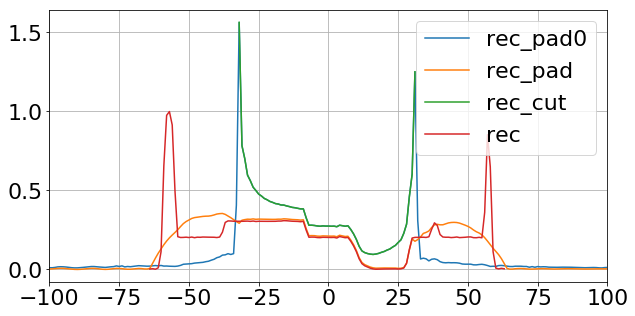

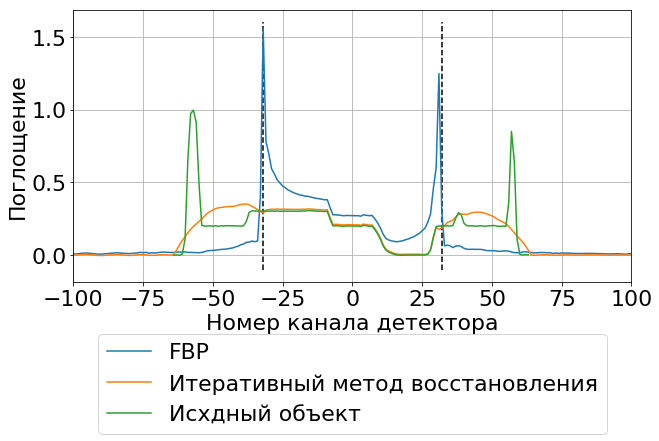

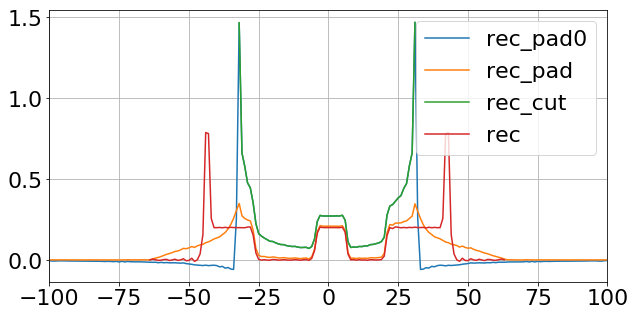

In [202]:
# # rec_plot = np.zeros_like(rec_pad)
# # rec_plot[150:-150,150:-150] = data
# def get_x_cut(data):
#     return np.arange(data.shape[0])-data.shape[0]//2, data[:,data.shape[1]//2]

# def get_y_cut(data):
#     return np.arange(data.shape[1])-data.shape[1]//2, data[data.shape[0]//2]
    
# plt.figure(figsize=(10,5))
# plt.plot(*get_x_cut(rec_pad0), label='rec_pad0')
# plt.plot(*get_x_cut(rec_pad), label='rec_pad')
# plt.plot(*get_x_cut(rec_cut), label='rec_cut')
# plt.plot(*get_x_cut(rec), label='rec')
# plt.grid()
# plt.legend(loc=0)
# plt.xlim(-100,100)
# plt.show()

# plt.figure(figsize=(10,5))
# plt.plot(*get_x_cut(rec_pad0), label='FBP')
# # plt.plot(*get_x_cut(rec_pad), label='rec_pad')
# plt.plot(*get_x_cut(rec_pad), label='Итеративный метод восстановления')
# plt.plot(*get_x_cut(rec), label='Исхдный объект')
# plt.vlines([-32,32],-0.1,1.6, 'k', '--')
# plt.grid()
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15))
# plt.xlim(-100,100)
# plt.ylabel('Поглощение')
# plt.xlabel('Номер канала детектора')
# plt.show()

# plt.figure(figsize=(10,5))
# plt.plot(*get_y_cut(rec_pad0), label='rec_pad0')
# plt.plot(*get_y_cut(rec_pad), label='rec_pad')
# plt.plot(*get_y_cut(rec_cut), label='rec_cut')
# plt.plot(*get_y_cut(rec), label='rec')
# plt.grid()
# plt.legend(loc=0)
# plt.xlim(-100,100)
# plt.show()


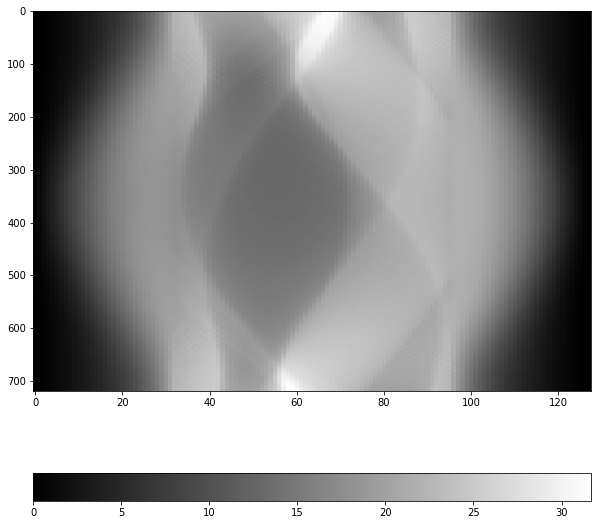

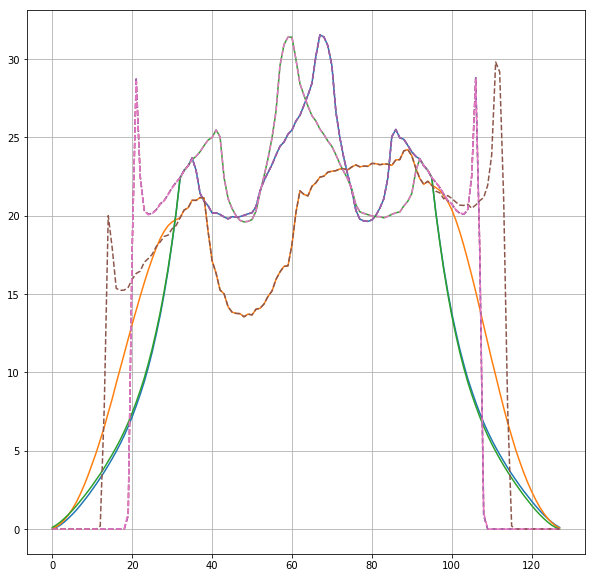

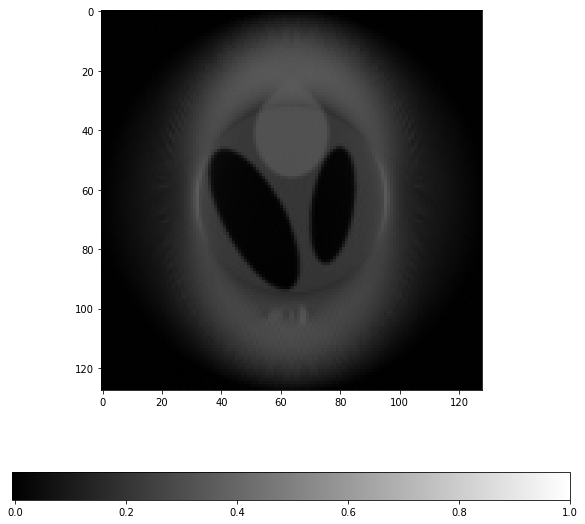

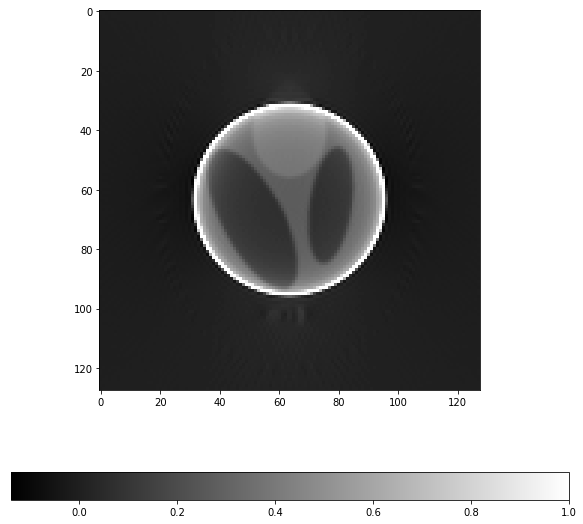

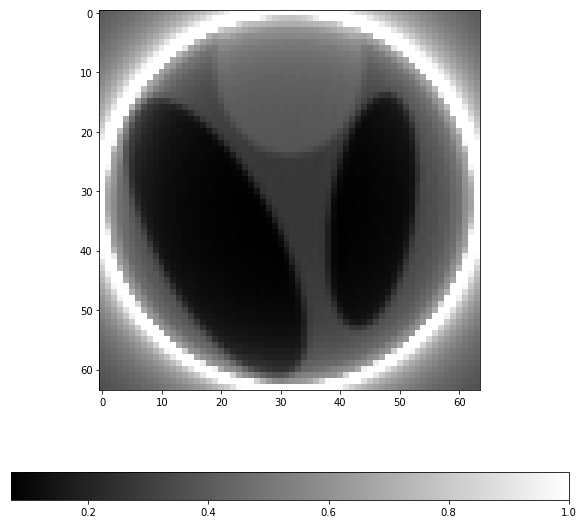

In [181]:
rec_pad, proj_geom, cfg = astra_tomo2d(sino, angles)

plt.figure(figsize=(10,10))
plt.imshow(sino[:, padsize-s_pad:-padsize+s_pad], cmap=plt.cm.gray, interpolation='nearest')
plt.colorbar(orientation='horizontal')
plt.axis('tight')
plt.show()

plt.figure(figsize=(10,10))
plt.plot(sino[0, padsize-s_pad:-padsize+s_pad])
plt.plot(sino[sino.shape[1]//2, padsize-s_pad:-padsize+s_pad])
plt.plot(sino[-1, padsize-s_pad:-padsize+s_pad])
plt.plot(sinogram[0, :],'--')
plt.plot(sinogram[0, :],'--')
plt.plot(sinogram[sino.shape[1]//2, :],'--')
plt.plot(sinogram[-1, :],'--')

plt.grid()
plt.show()


plt.figure(figsize=(10,10))
# plt.imshow(rec,vmin=0.1, vmax=0.2)
plt.imshow(rec_pad[rec_pad.shape[0]//2-rec.shape[0]//2:rec_pad.shape[0]//2+rec.shape[0]//2,
                  rec_pad.shape[0]//2-rec.shape[0]//2:rec_pad.shape[0]//2+rec.shape[0]//2],
           interpolation='nearest', cmap=plt.cm.gray,vmax=1)
plt.colorbar(orientation='horizontal')
plt.show()

plt.figure(figsize=(10,10))
# plt.imshow(rec,vmin=0.1, vmax=0.2)
plt.imshow(rec_pad0[rec_pad0.shape[0]//2-rec.shape[0]//2:rec_pad0.shape[0]//2+rec.shape[0]//2,
                  rec_pad0.shape[0]//2-rec.shape[0]//2:rec_pad0.shape[0]//2+rec.shape[0]//2],
           interpolation='nearest', cmap=plt.cm.gray,vmax=1)
plt.colorbar(orientation='horizontal')
plt.show()

plt.figure(figsize=(10,10))
# plt.imshow(rec,vmin=0.1, vmax=0.2)
plt.imshow(rec_cut,
           interpolation='nearest', cmap=plt.cm.gray,vmax=1)
plt.colorbar(orientation='horizontal')
plt.show()

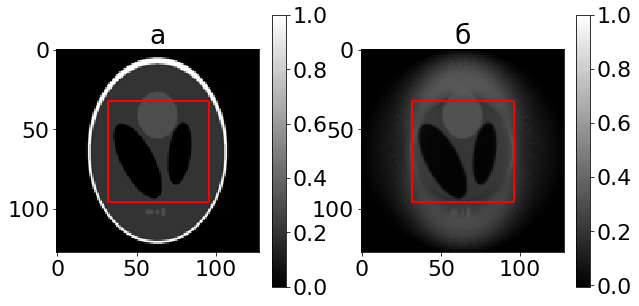

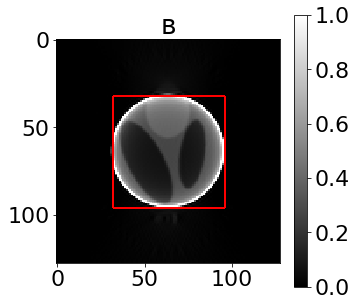

In [220]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(data, cmap=plt.cm.gray)
# plt.vlines([32,96],32,96, 'r', lw=2)
# plt.hlines([32,96],32,96, 'r', lw=2)
plt.title('а')
# plt.imshow(rec_pad[rec_pad.shape[0]//2-rec.shape[0]//2:rec_pad.shape[0]//2+rec.shape[0]//2,
#                   rec_pad.shape[0]//2-rec.shape[0]//2:rec_pad.shape[0]//2+rec.shape[0]//2],
#            interpolation='nearest', cmap=plt.cm.gray,vmax=1)
plt.colorbar(orientation='vertical')
# plt.show()

plt.subplot(122)
# plt.imshow(rec,vmin=0.1, vmax=0.2)
plt.imshow(rec_pad[rec_pad.shape[0]//2-rec.shape[0]//2:rec_pad.shape[0]//2+rec.shape[0]//2,
                  rec_pad.shape[0]//2-rec.shape[0]//2:rec_pad.shape[0]//2+rec.shape[0]//2],
           interpolation='nearest', cmap=plt.cm.gray,vmax=1)
# plt.vlines([32,96],32,96, 'r', lw=2)
# plt.hlines([32,96],32,96, 'r', lw=2)
plt.title('б')
plt.colorbar(orientation='vertical')
plt.show()

plt.figure(figsize=(5,5))
# plt.subplot(121)
# plt.imshow(rec,vmin=0.1, vmax=0.2)
plt.imshow(rec_pad0[rec_pad0.shape[0]//2-rec.shape[0]//2:rec_pad0.shape[0]//2+rec.shape[0]//2,
                  rec_pad0.shape[0]//2-rec.shape[0]//2:rec_pad0.shape[0]//2+rec.shape[0]//2],
           interpolation='nearest', cmap=plt.cm.gray,vmin=0, vmax=1)
# plt.vlines([32,96],32,96, 'r', lw=2)
# plt.hlines([32,96],32,96, 'r', lw=2)
plt.title('в')
plt.colorbar(orientation='vertical')
plt.show()


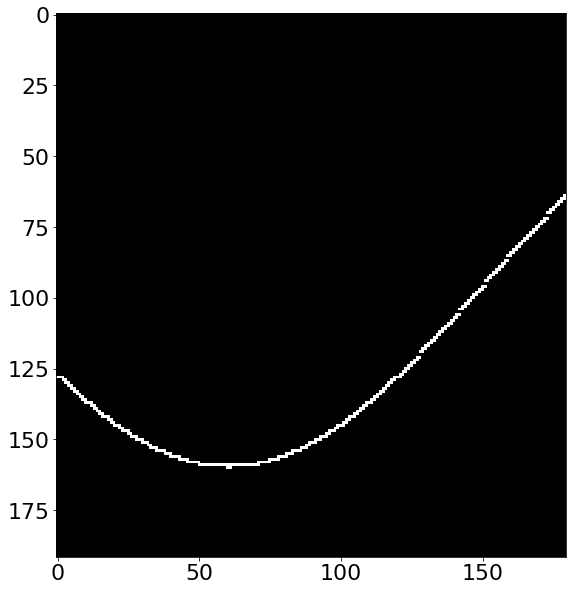

In [31]:
x = np.zeros((128*3//2,180))
for t in range(180):
    x[int(64*3//2+64*np.sin((t+30)/180.*np.pi)),t:t+2]=1
    
plt.figure(figsize=(10,10))
plt.imshow(x, cmap=plt.cm.gray)


In [32]:
import h5py

In [33]:
data_file = '/home/makov/diskmnt/big/robotom/8381fee8-a5cb-41d5-b6e5-4f5617458b46/tomo_rec.h5'

In [39]:
with h5py.File(data_file) as h5f:
    data = h5f['Reconstruction'][1200]

In [82]:
data[data<0]=0

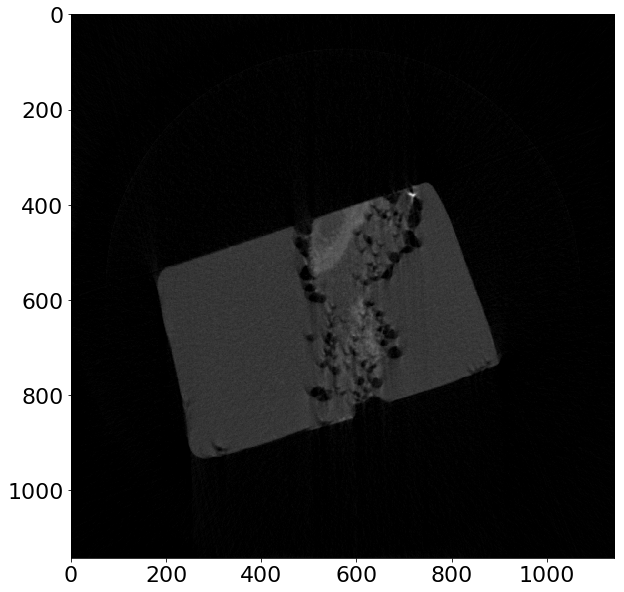

In [115]:
plt.figure(figsize=(10,10))
plt.imshow(data, cmap=plt.cm.gray)
# plt.colorbar()

In [116]:
angles = np.arange(0,180,1./10)*np.pi/180+0.3
sinogram = astra_build_sinogram(data, angles)

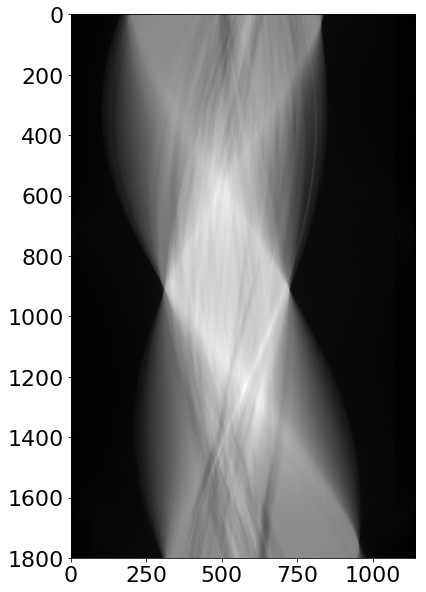

In [117]:
plt.figure(figsize=(10,10))
plt.imshow(sinogram, cmap=plt.cm.gray)
# plt.colorbar()

In [96]:
from cv2 import medianBlur

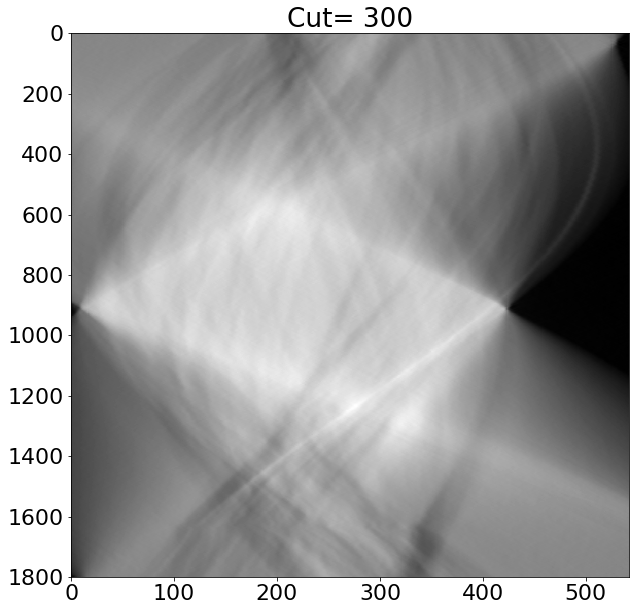

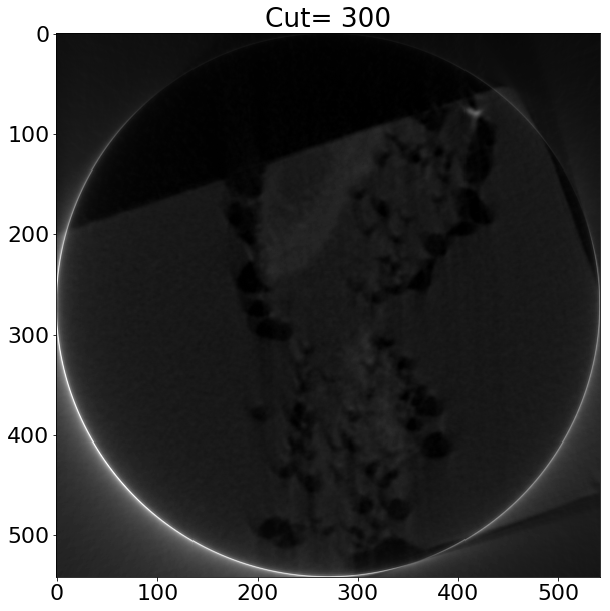

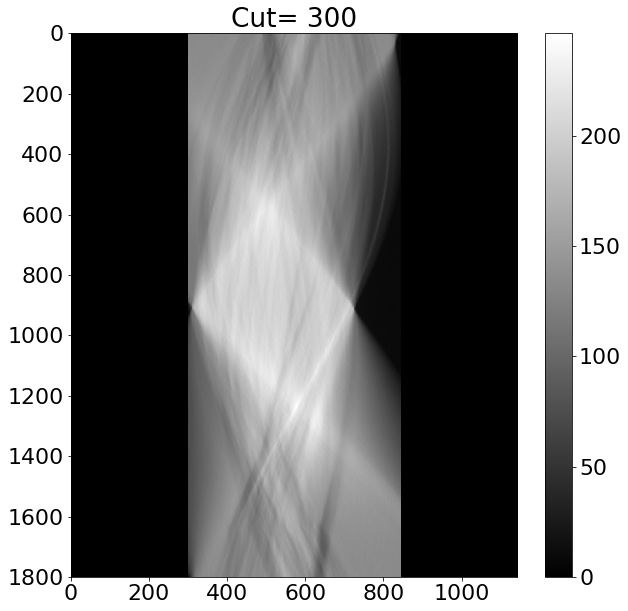

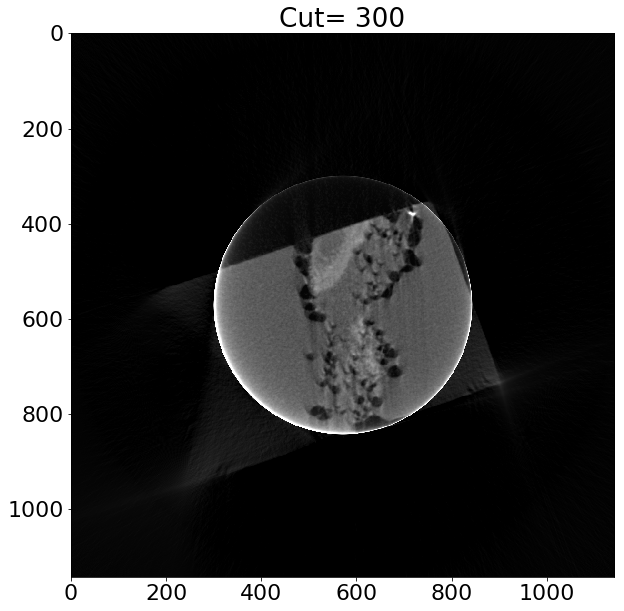

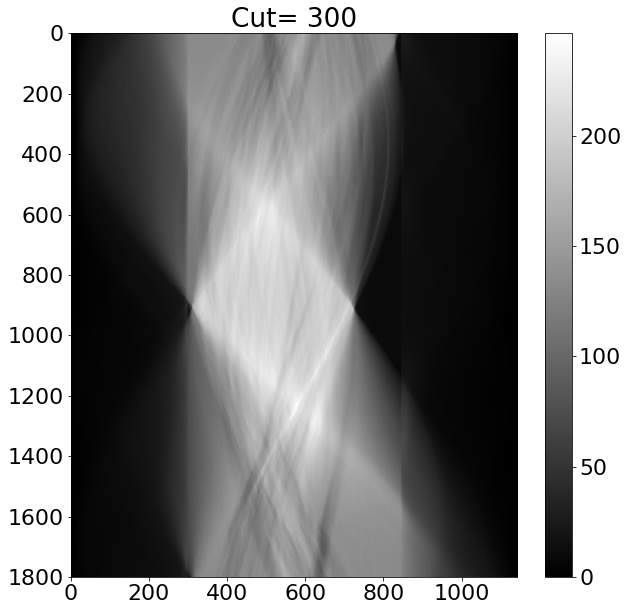

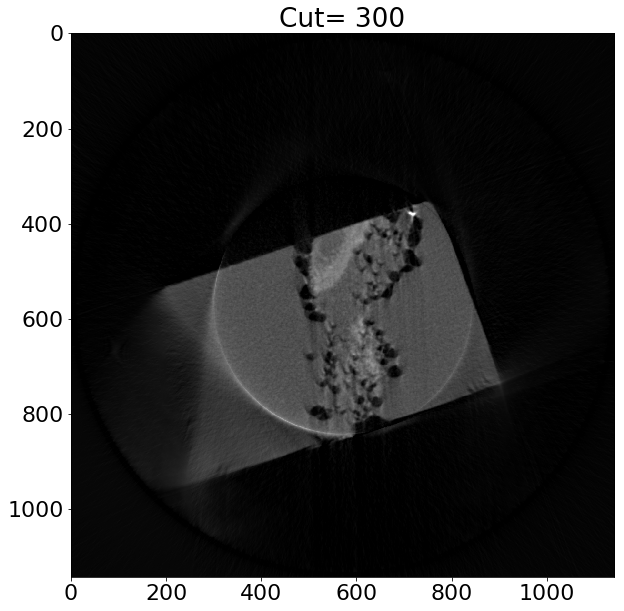

In [124]:
padsize=300
s_pad=padsize

sinogram_cut = sinogram[:,padsize:-padsize]
plt.figure(figsize=(10,10))
plt.imshow(sinogram_cut, cmap=plt.cm.gray, interpolation='nearest')
plt.axis('tight')
plt.title('Cut= {}'.format(s_pad))
plt.show()

rec_cut, proj_geom, cfg = astra_tomo2d(sinogram_cut, angles)

plt.figure(figsize=(10,10))
plt.imshow(rec_cut, interpolation='nearest', cmap=plt.cm.gray)
plt.title('Cut= {}'.format(s_pad))
plt.show()

#TODO: fixit
# padsize = s_pad*2*2

sinogram_padded = np.zeros((sinogram_cut.shape[0],sinogram_cut.shape[1]+padsize*2), dtype='float32')
sinogram_padded[:,padsize:-padsize] = sinogram_cut
rec_pad0, proj_geom, cfg = astra_tomo2d(sinogram_padded, angles)

plt.figure(figsize=(10,10))
plt.imshow(sinogram_padded, cmap=plt.cm.gray, interpolation='nearest')
plt.title('Cut= {}'.format(s_pad))
plt.axis('tight')
plt.colorbar()
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(rec_pad0, interpolation='nearest', cmap=plt.cm.gray, vmin=0, vmax=1)
plt.title('Cut= {}'.format(s_pad))
plt.show()

rec_pad, proj_geom, cfg = astra_tomo2d(sinogram_padded, angles)
sino = astra_build_sinogram(rec_pad, angles)
sino[:,padsize:-padsize] = sinogram_cut

# # max_radon=sino.sum(axis=1).max()

# MU = rec.sum()*2
X,Y = np.meshgrid(np.arange(rec_pad.shape[0]),np.arange(rec_pad.shape[1]))

X-=rec_pad.shape[0]//2
Y-=rec_pad.shape[1]//2

mask = (X**2+Y**2)<(rec_pad.shape[0]//2-10)**2  # Fix it in the up !

for i in log_progress(range(5000)):
    rec_pad, proj_geom, cfg = astra_tomo2d(sino, angles)
    rec_pad*=rec_pad>0
    rec_pad*=mask
    sino = astra_build_sinogram(rec_pad, angles)
    k = sino[:,padsize:-padsize].mean(axis=-1)/sinogram_cut.mean(axis=-1)
    if np.sum(np.argwhere(k==0))>0:
        break

    sino[:,padsize:-padsize] = sinogram_cut
    sino[:,0:padsize]=(sino[:,0:padsize].T/k).T
    sino[:,-padsize:]=(sino[:,-padsize:].T/k).T

    sino = (sino.T/sino.sum(axis=1)*sino.sum(axis=1).mean()).T
    sino = medianBlur(sino, 5)   # # Fix it in the up !
#     sino[sino>200]=200
    sino[:,padsize:-padsize] = sinogram_cut
    

rec_pad, proj_geom, cfg = astra_tomo2d(sino, angles)

plt.figure(figsize=(10,10))
plt.imshow(sino, cmap=plt.cm.gray, interpolation='nearest')
plt.title('Cut= {}'.format(s_pad))
plt.axis('tight')
plt.colorbar()
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(rec_pad, interpolation='nearest', cmap=plt.cm.gray,vmin=0, vmax=1)
plt.title('Cut= {}'.format(s_pad))
# plt.colorbar()
plt.show()